# FISHER FORECAST USING IM POWER SPECTRUM MULTIPOLES

This jupyter notebook is a general example of how to use the public code LIM (https://github.com/pcbreysse/lim) to compute the multipoles of the IM power spectrum and perform Fisher matrix forecasts. The results and plots obtained in this example correspond to the results reported in arXiv:1907.10067 and arXiv:1907.10065. 

Therefore, some of the functions, especially those including cosmological parameters or the astrophysical modeling, are specific of the assumptions and aims of the papers mentioned above. Nonetheless, tweak this notebook to apply it to any given line astrophysics model, cosmological model and experiment of interest should be straightforward (although it may require some hardcoding, please read this notebook carefully to be aware what you need to modify)

The functions used and defined in this notebook are commented, but some of the parameters and quantities used are only defined and explained in the LIM code. We refer to the code files (especially the descriptions of the classes defined in line_model.py and line_obs.py) to check the definitions of all input parameters.

First we import all the needed packages, And define the needed functions

In [1]:
# The next two lines are only needed if you have more than one 
# distribution of lim and need to specify the one you want
# import sys
# sys.path.insert(0, 'lim_pylians/')

from lim import lim

import numpy as np
from numpy.linalg import inv

import astropy.units as u
import astropy.constants as cu

from scipy.interpolate import interp1d as i1d
from scipy.interpolate import interp2d as i2d
from scipy.special import legendre

import camb

import pickle

from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import matplotlib.cm as cmap
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

%matplotlib inline



# TOOLS

General functions that facilitates plotting, saving and loading results and easy operations with them

In [2]:

def gaussian(x, mu, sig):
    '''
    Returns an unnormalized Gaussian distribution
    '''
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

###########################################################################

def save_obj(obj, name ):
    '''
    Saves the object (generally a list) using pickle
    '''
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
#################################################

def load_obj(name):
    '''
    Loads the object (generally a list) using pickle
    '''
    with open( name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
######################################################

def plot_2d(covmat,index,center,ax,color,TwoSigma=True,filled=True,factors=None,alpha=1,zorder=1):
    '''
    Paints 2d ellipses representing forecast constraints from the Fisher matrix. 
    Uses https://arxiv.org/pdf/0906.4123.pdf
    '''
    
    #define colors:
    red2 = '#fb9a99' # 2sigma
    red1 = '#e31a1c' # 1sigma
    
    blue2 = '#a6cee3' # 2sigma
    blue1 = '#1f78b4' # 1sigma
    
    green2 = '#b2df8a' # 2sigma
    green1 = '#33a02c' # 1sigma
    
    black1 = '#232323' # 1sigma
    black2 = '#A9A9A9' # 2sigma
    
    maroon1 = 'maroon'
    maroon2 = 'lightsalmon'
    
    yellow1 = 'darkgoldenrod'
    yellow2 = 'gold'
    
    grey1 = 'slategrey'
    grey2 = 'beige'
    
    if color == 'red':
        clr = [red1,red2]
    elif color == 'blue':
        clr = [blue1,blue2]
    elif color == 'green':
        clr = [green1,green2]
    elif color == 'black':
        clr = [black1,black2]
    elif    color == 'maroon':
        clr = [maroon1,maroon2]
    elif    color == 'yellow':
        clr = [yellow1,yellow2]
    elif color == 'grey':
        clr = [grey1,grey2]
    else:
        clr = [color,color]
    
    #Define the 2x2 covariance matrix from the covariance matrix obtained from the inverse of the Fisher
    matrix = covmat[np.ix_(index,index)]
    
    #Rescale the errors if needed
    if factors: 
        s1 = matrix[0,0]**0.5*factors[0]
        s2 = matrix[1,1]**0.5*factors[1]
        s12 = matrix[0,1]*factors[0]*factors[1]
        center[0] *= factors[0]
        center[1] *= factors[1]
    else:
        s1 = matrix[0,0]**0.5
        s2 = matrix[1,1]**0.5
        s12 = matrix[0,1]
        
    rho = s12/s1/s2
    print( 'correlation =', rho)
    #1sigma and 2sigma Delta chi2
    Deltachi2 = 2.3
    TwoSigmaDeltachi2 = 6.17
    
    xpar = np.linspace(-4*s1,4*s1,128)
    ypar = np.linspace(-4*s2,4*s2,128)
    xi_grid, yi_grid = np.meshgrid(xpar,ypar)
    #Define contours (ellipses) corresponding to chi2
    chi2 = ((xi_grid/s1)**2+(yi_grid/s2)**2-2.*rho*(xi_grid/s1)*(yi_grid/s2))/(1-rho**2)
    
    #Paint the contours
    if filled:
        if TwoSigma:
            ax.contourf(xi_grid+center[0],yi_grid+center[1],chi2,[0,TwoSigmaDeltachi2],colors=clr[1],alpha=alpha)
        ax.contourf(xi_grid+center[0],yi_grid+center[1],chi2,[0,Deltachi2],colors=clr[0],alpha=alpha)
    if TwoSigma:
        ax.contour(xi_grid+center[0],yi_grid+center[1],chi2,[TwoSigmaDeltachi2],colors='k',linewidths=1.5,alpha=alpha)
    ax.contour(xi_grid+center[0],yi_grid+center[1],chi2,[Deltachi2],colors='k',linewidths=1.5,alpha=alpha)

    ax.scatter(center[0],center[1],marker='o',color='k',s=50,zorder=4)
    return

##########################################################

def merge_dicts(D):
    '''
    Merges dictionaries
    '''
    dic = {}
    for k in D:
        dic.update(k)
    return dic

################################################################

def log_interp1d(xx, yy, kind='linear',bounds_error=False,fill_value='extrapolate'):
    '''
    log-log interpolation
    '''
    try:
        logx = np.log10(xx.value)
    except:
        logx = np.log10(xx)
    try:
        logy = np.log10(yy.value)
    except:
        logy = np.log10(yy)
    lin_interp = i1d(logx, logy, kind=kind,bounds_error=bounds_error,fill_value=fill_value)
    
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))

    return log_interp

#########################################################

def get_multipoles(M,Pkclus, Pshot):
    '''
    Gets the IM P(k) multipoles from Pkclus and Pshot. If no AP needed,
    you can use directly M.Pk_0, M.Pk_2, M.Pk_4
    '''
    L2 = legendre(2)(M.mui_grid)
    L4 = legendre(4)(M.mui_grid)
    
    PK0 = 0.5*np.trapz(Pkclus+Pshot,M.mu,axis=0)
    PK2 = 2.5*np.trapz((Pkclus+Pshot)*L2,M.mu,axis=0)
    PK4 = 4.5*np.trapz((Pkclus+Pshot)*L4,M.mu,axis=0)

    return PK0,PK2,PK4

########################################################

def correlation_matrix(covmat):
    '''
    Obtains the correlation matrix from the covariance matrix
    '''
    var = np.diag(covmat)
    corr = np.eye(covmat.shape[0])
    for i in range(covmat.shape[0]):
        for j in range(i+1,covmat.shape[0]):
            corr[i,j] = covmat[i,j]/(var[i]*var[j])**0.5
            corr[j,i] = corr[i,j]
    return corr

##############################################################

def write_vals(corr,ax):
    '''
    Write the value of corr in the corresponding box in the plot
    '''
    for i in range(corr.shape[0]):
        for j in range(i+1,corr.shape[0]):
            ax.text(j,i,'{:1.2f}'.format(corr[i,j]),fontsize=20,color='white',
                    horizontalalignment='center',verticalalignment='center',
                   fontweight='bold')
            ax.text(i,j,'{:1.2f}'.format(corr[j,i]),fontsize=20,color='white',
                    horizontalalignment='center',verticalalignment='center',
                   fontweight='bold')
    return

##################################################################



# Cosmological and Astrophysical Model

Define both your cosmological and astrophysical model assumed to compute the fiducial model. It will only be used for the fiducial. Variations will be computed by updating your LIM object

The definition of the astrophysical model must match with one of the options existing in the LIM code. In any case, any of the entries of the dictionary "astromodel" can be changed

In [3]:
def prepare_model(NZ,kkind='linear',model='TonyLi',smooth=True):
    '''
    Fiducial cosmological parameters
    '''
    omega_b = 0.0224218
    omega_cdm = 0.119328
    H0 = 67.6637
    ns = 0.96649
    logA = 3.0466
    fNL = 0
    mnu = 0.06
    
    cosmo_fid = dict(cosmo_input={'H0':H0,'ombh2':omega_b,'omch2':omega_cdm,
                                  'As':np.exp(logA)*1e-10,'f_NL':fNL,'ns':ns,'mnu':mnu})
    
    #RSD term and Fingers-of-Gof sigma parameter. If not wanted, 'do_RSD':False
    RSD = {'do_RSD':True,'sigma_NL':7.*u.Mpc}
    
    #k range
    krange = {'nk':256,'k_kind':kkind,'nmu':10000}
    
    #non-linear P_m(k)
    nonlinear = {'nonlinear_pm':True}
    
    #NO smoothed P(k)
    smooth = {'smooth':smooth}
    
    if model == 'LF': 
        astromodel = {'hmf_model':'Tinker10','bias_model':'Tinker10',
             'model_type':'LF','model_name':'SchCut','model_par':dict(phistar=9.6e-11*u.Lsun**-1*u.Mpc**-3,
                     Lstar=2.1e6*u.Lsun,alpha=-1.87,Lmin=5000*u.Lsun)}
    elif model == 'TonyLi':
        astromodel = {'sigma_scatter':0.3,'hmf_model':'Tinker10','bias_model':'Tinker10',
                 'model_type':'ML','model_par':{'alpha':1.37, 'beta':-1.74, 'dMF':1.0,\
        'BehrooziFile':'sfr_release.dat','sig_SFR':0.3},'model_name':'TonyLi'}
    elif model == 'GongHalpha':
        astromodel = {'sigma_scatter':0.,'hmf_model':'Tinker10','bias_model':'Tinker10',
                 'model_type':'ML','model_par':{'Aext':1.,'K_Halpha':1.27,'SFR_file':'Gong16_SFR_params.dat'},'model_name':'GongHalpha','do_Jysr':True,
                    'Mmin':1e8*u.Msun}
    elif model == 'SilvaLyalpha_12':
        astromodel = {'sigma_scatter':0.,'hmf_model':'Tinker10','bias_model':'Tinker10',
                 'model_type':'ML','model_par':{'SFR_file':'Silva15_SFR_params.dat',
                                               'RLya':1.1,'Aext':1.,'fLyaesc':0.2,
                                               'fUVesc':0.2},'model_name':'SilvaLyalpha_12','do_Jysr':True,
                    'Mmin':1e8*u.Msun}
    elif model == 'SilvaCII_15':
        astromodel = {'sigma_scatter':0.,'hmf_model':'Tinker10','bias_model':'Tinker10',
                 'model_type':'ML','model_par':{'SFR_file':'Silva15_SFR_params.dat',
                                               'a':1.,'b':6.9647},'model_name':'SilvaCII','do_Jysr':True,
                    'Mmin':1e8*u.Msun}
    else:
        raise Exception("Choose a model between: 'LF','TonyLi',GongHalpha,'SilvaLyalpha_12','SilvaCII_15'")
        #Change as needed

    #Merge the dictionaries and output
    MOD = merge_dicts([cosmo_fid,RSD,krange,astromodel,nonlinear,smooth])
    
    return MOD


# Survey description

Include the specification of your survey(s) as needed. This is needed to know the observed redshift and the covariance of the IM power spectrum.

nuObs and Delta_nu are the observed survey frequency and frequency band of the experiment, respectively. Input a list where each entry corresponds to a redshift bin

In [4]:
def survey_pars(survey):
    '''
    Defines each possible survey with a given name
    '''
    if survey == 'COMAP_1':
        #Rest frame frequency of the targeted line
        freq = {'nu':115.271*u.GHz} #CO(1-0) line
        Tsys = np.ones(1)*40*u.K
        obs = dict(Nfeeds=19, beam_FWHM=4*u.arcmin, 
                    tobs=6000*u.hr, 
                    Omega_field=2.25*u.deg**2, Nfield=1)
        nuObs = [30*u.GHz]
        Delta_nu = [8*u.GHz]
        dnu = np.ones(1)*15.6*u.MHz
    elif survey == 'COMAP_2':
        #Rest frame frequency of the targeted line
        freq = {'nu':115.271*u.GHz} #CO(1-0) line
        Tsys = np.ones(1)*40*u.K
        obs = dict(Nfeeds=95, beam_FWHM=4*u.arcmin, 
                    tobs=10000*u.hr, 
                    Omega_field=60.*u.deg**2, Nfield=1)
        nuObs = [30*u.GHz]
        Delta_nu = [8*u.GHz]
        dnu = np.ones(1)*8.*u.MHz
    elif survey == 'IMS3':
        #Rest frame frequency of the targeted line
        freq = {'nu':115.271*u.GHz} #CO(1-0) lin
        Tsys = np.ones(5)*20*u.K
        obs = dict(Nfeeds=1000, beam_FWHM=4*u.arcmin, 
                    tobs=10000*u.hr, 
                    Omega_field=1000*u.deg**2, Nfield=1)
        nuObs = [30.9*u.GHz,23.0*u.GHz,18.3*u.GHz,15.2*u.GHz,13.*u.GHz]
        Delta_nu = [10.2*u.GHz,5.6*u.GHz,3.8*u.GHz,2.4*u.GHz,2.0*u.GHz]
        dnu = np.ones(5)*2.*u.MHz
    elif survey == 'IMS3_1zbin':
        #Rest frame frequency of the targeted line
        freq = {'nu':115.271*u.GHz} #CO(1-0) line
        Tsys = np.ones(1)*20*u.K
        obs = dict(Nfeeds=1000, beam_FWHM=4*u.arcmin, 
                    tobs=10000*u.hr, 
                    Omega_field=1000*u.deg**2, Nfield=1)
        nuObs = [24.*u.GHz]
        Delta_nu = [24.*u.GHz]
        dnu = np.ones(1)*2.*u.MHz
    elif survey == 'SPHEREx_deep_Lyalpha':
        #Rest frame frequency of the targeted line
        freq = {'nu':2465398.5*u.GHz} #Lyman-alpha line
        nu = {'':2465398.5*u.GHz}
        obs = dict(beam_FWHM=6.2*u.arcsec, 
                    Omega_field=200*u.deg**2, Nfield=1,Nfeeds=1)
        Delta_nu = np.array([67758.56921945, 48116.20776083, 63412.8694707])*u.GHz
        Tsys = np.array([3.84417279e-08,4.00342445e-08,3.9390538e-08])*u.Jy*u.s**(1./2)
        nuObs = np.array([365843.99272361, 307906.60423347, 252142.0656177])*u.GHz
        R = 41.4
        dnu = nuObs/R
    elif survey == 'SPHEREx_deep_Halpha':
        #Rest frame frequency of the targeted line
        freq = {'nu':456805.72*u.GHz} #Halpha line
        obs = dict(beam_FWHM=6.2*u.arcsec, 
                    Omega_field=200*u.deg**2, Nfield=1,Nfeeds=1)
        Delta_nu = [209524.68686398*u.GHz, 65410.64140044*u.GHz, 31933.35282898*u.GHz,20089.43653119*u.GHz]
        Tsys = np.array([4.03230489e-08,3.71395225e-08,2.92511774e-08,2.8708819e-08])*u.Jy*u.s**(1./2)
        nuObs = np.array([294960.93390134,157493.26976913,108821.27265442,82809.87797433])*u.GHz
        R = 41.4
        dnu = nuObs/R
    elif survey == 'CII_stageII':
        #Rest frame frequency of the targeted line
        freq = {'nu':1900.539*u.GHz} #CII lin
        Tsys = np.ones(2)*5e-3*u.Jy*u.s**0.5
        obs = dict(Nfeeds=64, beam_FWHM=0.5*u.arcmin, 
                    tobs=2000*u.hr, 
                    Omega_field=100*u.deg**2, Nfield=1)
        nuObs = np.array([275.13333765, 225.13333765])*u.GHz
        Delta_nu = np.array([49.73332469, 50.26667531])*u.GHz
        dnu = np.ones(2)*0.4*u.GHz
    elif survey == 'CCAT':
        #Rest frame frequency of the targeted line
        freq = {'nu':1900.539*u.GHz} #CII lin
        Tsys = np.array([230,140,81,81])*u.mJy*u.s**0.5
        obs = dict(Nfeeds=6144, beam_FWHM=44*u.arcsec, 
                    tobs=2000*u.hr, 
                    Omega_field=4*u.deg**2, Nfield=2)
        nuObs = np.array([410,350,280,220])*u.GHz
        Delta_nu = np.array([20,20,20,20])*u.GHz
        dnu = np.array([4.1, 3.5, 2.8, 2.2])*u.GHz
    else:
        raise TypeError("Please, choose survey=='COMAP_1','COMAP_2','IMS3','IMS3_1zbin'\
                                                'SPHEREx_deep_Lyapha','SPHEREx_deep_Halpha','CII_stageII', 'CCAT'")
    return obs,nuObs,Delta_nu,dnu,freq,Tsys

#############################################################################

def nuBins(nu,nuobs_min,nuobs_max,Delta):
    '''
    Obtains the observed frequency and frequency bands for each redshift bin of the experiment, fulfilling:
    log_10(Delta(1+z)) = log_10(Delta(nu/nu_obs)) = Delta
    Hardcode the output of this function in survey_pars function as needed
    '''
    ret = np.array([nuobs_max.value])
    a = nuobs_max
    while a>nuobs_min:
        a = a/(1.+10.**Delta*a/nu)
        ret = np.append(ret,a.value)
    ret = ret[:-1]
    ret[-1] = nuobs_min.value
    return 0.5*(ret[:-1]+ret[1:])*nu.unit,-np.diff(ret)*nu.unit


# Get fiducial IM P(k) and derivatives

Needed functions to compute the fiducial IM power spectrum multipoles, corresponding covariances and the derivatives of the parameters of interest. In addition, functions to save them are included

In [5]:
def fiducial(M):
    '''
    Fiducial values of the measured/varied parameters in the analysis.
    In this case, it corresponds to: mnu,fNL,alpha_perp,alpha_par,Tfs8,Tbs8,sigma_FoG,T^2
        but the list can contain any parameter always that it is consistenly used in this cell
        Note that T and T^2 means here the mean brightness temperature and its variance
    Same order in step(),namefile(), and read always that vecparam is used
    '''
    return [0.06,0.,1.,1.,M.Tmean*M.cosmo.get_fsigma8()[0],
            M.Tmean*M.bavg.value*M.transfer.sigma_8[0],M.sigma_NL,M.L2mean*M.CLT**2.]

####################################################

def step():
    '''
    Steps to compute numerical derivatives with respect to the cosmological parameters when needed
    '''
    return [0.02,'nostep',0.002,0.002,
            'nostep','nostep','nostep','nostep']

################################################################

def namefile(NZ,par):
    '''
    Suffix for the names of the file where the varied IM P(k) will be stored
    '''
    LIST = ['mnu','fNL','alpha_perp','alpha_par','Tfs8',
            'Tbs8','sigma_NL','T2mean']
    return LIST[par]

##################################################################

def Pk_AP(M,vecparam,smooth=True):
    '''
    Computes the power spectrum for a set of parameters given by vecparam(same order than in fiducial)
    Returns clustering and shotnoise terms by separate, as well as the corresponding k and mu after accounting
        for the Alcock-Paczynski effect.
    If Alcock-Paczynski effect is to be ignored, you can directly use M.Pk, M.Pk_clust and M.Pk_shot without 
        using this function (although be aware of the smooth input parameter)
    '''
    mnu,fNL,alpha_perp,alpha_par,Tfs8,Tbs8,sNL,T2mean = vecparam
    F = alpha_par/alpha_perp
    prefac = 1./alpha_perp**2/alpha_par
    
    #Get "real" k and mu
    kprime = np.zeros((len(M.mu),len(M.k)))
    mu_prime = M.mui_grid/F/np.sqrt(1.+M.mui_grid**2.*(1./F/F-1))
    for imu in range(M.nmu):
        kprime[imu,:] = M.k/alpha_perp*np.sqrt(1.+M.mu[imu]**2*(1./F/F-1))
    #Obtain the corresponding P_m for the "real" k
    Pmprime = log_interp1d(M.k,M.Pm[0,:])(kprime)*M.Pm.unit
    #Apply RSD for the "real" mu
    kaiser = (Tbs8+Tfs8*mu_prime**2)**2
    loren = 1./(1.+0.5*(kprime*mu_prime*sNL.value)**2)
    
    #Units change depend on the survey. Autoconsistent definition in terms of Mpc/h
    Pkclus = (prefac*kaiser*Pmprime/M.transfer.sigma_8[0]**2*loren**2).to(M.Mpch**3*T2mean.unit/u.Mpc**3)
    Pshot = prefac*T2mean.to(M.Mpch**3*T2mean.unit/u.Mpc**3)
    
    if smooth:
        #smooth the power spectrum multiplying by the beam/channel window function
        return M.Wk*Pkclus, M.Wk*Pshot, kprime, mu_prime
    else:
        return Pkclus, Pshot, kprime, mu_prime

#############################################################################

def get_Pk_diff(SURVEY,model='TonyLi',kkind='linear',smooth=True):
    '''
    Front function to call and obtain the needed quantities to compute the Fisher Matrix
    
    Computes the fiducial power spectrum, the covariance, and the corresponding derivatives for the Fisher
    '''
    #Add the suffix of your astromodel to the file name
    modelname = ''
    if model == 'TonyLi':
        modelname = '_TonyLi'
    elif model == 'LF':
        modelname = '_LF'
    elif model== 'GongHalpha':
        modelname = '_Halpha'
    elif model== 'SilvaLyalpha_12':
        modelname = '_Lyalpha'
        
    #Load survey specs
    obs,NUOBS,DELTANU,dnu,freq,Tsys = survey_pars(survey=SURVEY)
    #Number of zbins
    NZ = len(NUOBS)
    #Load fiducial model
    fidmod = prepare_model(NZ,kkind=kkind,model=model,smooth=smooth)
    
    print(  SURVEY + ' survey has {0:2d} redshift bin(s)'.format(NZ))

    #Get the steps for numerical derivatives
    st = step()
    for iz in range(0,NZ):
        #get input parameters
        INPUT = merge_dicts([fidmod,obs,dict(nuObs=NUOBS[iz],Delta_nu=DELTANU[iz],Tsys_NEFD=Tsys[iz],dnu=dnu[iz]),freq])
        #Call lim
        M = lim(INPUT)
        M.update(kmin = M.kmin_field)
        
        #In case you want to limit the maximum k.
        M.update(kmax = min(1.*M.Mpch**-1,M.kmax_field.to(M.Mpch**-1)))
        #M.update(kmax = M.kmax_field) #In case you don't want to limit the maximum k, this is the survey limit

        #For frequency varying Tsys (set up for the IMS3 Tsys model)
        if M.nuObs > 20.*u.GHz and 'IMS3' in SURVEY:
            M.update(Tsys_NEFD=M.nuObs/u.GHz*u.K)
        
        #namefiles
        name = 'output/Pk_'+SURVEY+'_z'+str(iz)+modelname
        if kkind == 'log':
            name = 'output/logk_Pk_'+SURVEY+'_z'+str(iz)+modelname
        namefid = name +'_fid.txt'
        print(namefid)

        #Obtain the fiducial IM Pk multipoles
        vecparam = fiducial(M)
        #We work in h/Mpc units
        khfid = M.k.to(M.Mpch**-1)
        Pkclus, Pshot, kprime, muprime = Pk_AP(M,vecparam,smooth=smooth)
        #To use same functions as for the derivatives, but M.Pk_0, M.Pk_2 and M.Pk_4 could have been used
        P0,P2,P4 = get_multipoles(M,Pkclus, Pshot)

        #Get the covariances blocks
        #Units change depend on the survey. Autoconsistent definition in terms of Mpc/h
        covmat_00 = M.covmat_00.to(M.Mpch**6*vecparam[-1].unit**2/u.Mpc**6)
        covmat_02 = M.covmat_02.to(M.Mpch**6*vecparam[-1].unit**2/u.Mpc**6)
        covmat_04 = M.covmat_04.to(M.Mpch**6*vecparam[-1].unit**2/u.Mpc**6)
        covmat_22 = M.covmat_22.to(M.Mpch**6*vecparam[-1].unit**2/u.Mpc**6)
        covmat_24 = M.covmat_24.to(M.Mpch**6*vecparam[-1].unit**2/u.Mpc**6)
        covmat_44 = M.covmat_44.to(M.Mpch**6*vecparam[-1].unit**2/u.Mpc**6)

        #Save the file using the LIM's save_in_file function
        #It will be used by the Fisher Matrix Functions
        M.save_in_file(namefid,[khfid,P0,P2,P4,
                                covmat_00,covmat_02,
                                covmat_04,covmat_22,
                                covmat_24,covmat_44])
        
        #Now compute the derivatives and save them
        #Some are numerical (i.e., mnu, alpha_perp, alpha_par) and others analytic (see next cell)
        for ipar in range(len(st)):
            #namefile
            namedif = name +'_'+namefile(NZ,ipar)+'.txt'
            #keep track
            print( ipar, namedif)
            #Example of a numerical derivative (all of them are equal)
            if ipar == 0:#mnu
                #Get the fiducial + step cosmology
                temp = vecparam[0] + st[ipar]
                M.update(cosmo_input=dict(mnu=temp))
                #Get the power spectrum multipoles
                Pkclus_plus, Pshot_plus, kprime_plus, muprime_plus = Pk_AP(M,vecparam,smooth=smooth)
                P0_plus,P2_plus,P4_plus = get_multipoles(M,Pkclus_plus, Pshot_plus)
                #Do the same for fiducial - step
                temp = vecparam[0] - st[ipar]
                M.update(cosmo_input=dict(mnu=temp))
                Pkclus_minus, Pshot_minus, kprime_minus, muprime_minus = Pk_AP(M,vecparam,smooth=smooth)
                P0_minus,P2_minus,P4_minus = get_multipoles(M,Pkclus_minus, Pshot_minus)
                #Save results to a file
                M.save_in_file(namedif,[khfid,P0_plus,P2_plus,P4_plus,P0_minus,P2_minus,P4_minus])
                #Come back to the fiducial cosmology
                M.update(cosmo_input=dict(mnu=vecparam[0]))
            #Example of an analytic derivative. All of them are equal except for the derivative_XXX() function
            if ipar == 1:#fNL
                #Get analytic P(k,mu) and the multipoles, and the save it
                Pkclus_der, Pshot_der = derivative_fNL(M,vecparam,Pkclus,Pshot)
                P0_der,P2_der,P4_der = get_multipoles(M,Pkclus_der, Pshot_der)
                M.save_in_file(namedif,[khfid,P0_der,P2_der,P4_der])
            if ipar == 2:#alpha_perp
                vecparam[2] += st[ipar]
                Pkclus_plus, Pshot_plus, kprime_plus, muprime_plus = Pk_AP(M,vecparam,smooth=smooth)
                P0_plus,P2_plus,P4_plus = get_multipoles(M,Pkclus_plus, Pshot_plus)
                vecparam[2] -= 2*st[ipar]
                Pkclus_minus, Pshot_minus, kprime_minus, muprime_plus = Pk_AP(M,vecparam,smooth=smooth)
                P0_minus,P2_minus,P4_minus = get_multipoles(M,Pkclus_minus, Pshot_minus)
                M.save_in_file(namedif,[khfid,P0_plus,P2_plus,P4_plus,P0_minus,P2_minus,P4_minus])
                vecparam[2] += st[ipar]
            if ipar == 3:#alpha_par
                vecparam[3] += st[ipar]
                Pkclus_plus, Pshot_plus, kprime_plus, muprime_plus = Pk_AP(M,vecparam,smooth=smooth)
                P0_plus,P2_plus,P4_plus = get_multipoles(M,Pkclus_plus, Pshot_plus)
                vecparam[3] -= 2*st[ipar]
                Pkclus_minus, Pshot_minus, kprime_minus, muprime_plus = Pk_AP(M,vecparam,smooth=smooth)
                P0_minus,P2_minus,P4_minus = get_multipoles(M,Pkclus_minus, Pshot_minus)
                M.save_in_file(namedif,[khfid,P0_plus,P2_plus,P4_plus,P0_minus,P2_minus,P4_minus])
                vecparam[3] += st[ipar]
            if ipar == 4:#Tfs8
                Pkclus_der, Pshot_der = derivative_Tfs8(M,vecparam,Pkclus,Pshot)
                P0_der,P2_der,P4_der = get_multipoles(M,Pkclus_der, Pshot_der)
                M.save_in_file(namedif,[khfid,P0_der,P2_der,P4_der])
            if ipar == 5:#Tbs8
                Pkclus_der, Pshot_der = derivative_Tbs8(M,vecparam,Pkclus,Pshot)
                P0_der,P2_der,P4_der = get_multipoles(M,Pkclus_der, Pshot_der)
                M.save_in_file(namedif,[khfid,P0_der,P2_der,P4_der])
            if ipar == 6:#sNL
                Pkclus_der, Pshot_der = derivative_sNL(M,vecparam,Pkclus,Pshot)
                P0_der,P2_der,P4_der = get_multipoles(M,Pkclus_der, Pshot_der)
                M.save_in_file(namedif,[khfid,P0_der,P2_der,P4_der])
            if ipar == 7:#T2mean
                Pkclus_der, Pshot_der = derivative_T2mean(M,vecparam,Pkclus,Pshot)
                P0_der,P2_der,P4_der = get_multipoles(M,Pkclus_der, Pshot_der)
                M.save_in_file(namedif,[khfid,P0_der,P2_der,P4_der])
            
    return



We use analytic derivatives whenever is possible for the sake of accuracy and efficiency. Add more derivatives if you need them. Note that if you have change the cosmological parameters considered int he analysis, you need to modify the first line of each of these functions, which read vecparam

These functions are used by get_Pk_diff()

In [6]:

#############################################################################################

def derivative_fNL(M,vecparam,Pkclus,Pshot):
    mnu,fNL,alpha_perp,alpha_par,Tfs8,Tbs8,sNL,T2mean = vecparam
    dc = 1.686
    factor = 3.*M.camb_pars.omegam*(100.*M.hubble*(u.km/u.s/u.Mpc))**2./   \
                     (cu.c.to(u.km/u.s)**2.*M.k2Tk)
    return (2.*Pkclus*(M.bavg-1.)*factor/(M.bavg+(M.bavg-1)*fNL*factor+
                    M.cosmo.get_fsigma8()[0]/M.cosmo.get_sigma8()[0])).to(M.Mpch**3*T2mean.unit/u.Mpc**3),np.zeros(M.ki_grid.shape)*M.Mpch**3*T2mean.unit/u.Mpc**3

###########################################################################

def derivative_Tfs8(M,vecparam,Pkclus,Pshot):
    mnu,fNL,alpha_perp,alpha_par,Tfs8,Tbs8,sNL,T2mean = vecparam
    return (2.*Pkclus*(M.mui_grid**2/(Tbs8+Tfs8*M.mui_grid**2))).to(M.Mpch**3*M.Tmean.unit),np.zeros(M.ki_grid.shape)*M.Mpch**3*M.Tmean.unit

#####################################################################

def derivative_Tbs8(M,vecparam,Pkclus,Pshot):
    mnu,fNL,alpha_perp,alpha_par,Tfs8,Tbs8,sNL,T2mean = vecparam
    return (2.*Pkclus/(Tbs8+Tfs8*M.mui_grid**2)).to(M.Mpch**3*M.Tmean.unit),np.zeros(M.ki_grid.shape)*M.Mpch**3*M.Tmean.unit

####################################################################################

def derivative_sNL(M,vecparam,Pkclus,Pshot):
    mnu,fNL,alpha_perp,alpha_par,Tfs8,Tbs8,sNL,T2mean = vecparam
    return (-2.*Pkclus*sNL*(M.ki_grid*M.mui_grid)**2./(1.+0.5*(sNL*M.ki_grid*M.mui_grid)**2.)).to(M.Mpch**2*T2mean.unit/u.Mpc**3),np.zeros(M.ki_grid.shape)*M.Mpch**2*T2mean.unit/u.Mpc**3

##################################################################################

def derivative_T2mean(M,vecparam,Pkclus,Pshot):
    mnu,fNL,alpha_perp,alpha_par,Tfs8,Tbs8,sNL,T2mean = vecparam
    return np.zeros(M.ki_grid.shape)*M.Mpch**3/u.Mpc**3,(Pshot/T2mean)


# Fisher Matrix functions

This cell includes the functions needed to compute the Fisher Matrix. In order to avoid the computation of the IM power spectrum every time, it read the files where the IM power spectrum, covariances and derivatives are stored and compute the Fisher Matrix. 

In [7]:

def read_fid(SURVEY,name1,name2,hexadec):
    '''
    Read the files corresponding to the fiducial IM power spectrum and the covariance 
    '''
    #Get NZ
    obs,NUOBS,DELTANU,dnu,freq,Tsys = survey_pars(survey=SURVEY)
    NZ = len(NUOBS)
    #List of indeces whether you want the hexadecapole or not
    if hexadec:
        Nmul = 3
        ind = [0,1,2,1,3,4,2,4,5]
    else:
        Nmul = 2
        ind = [0,1,1,3]
    
    #Read quickly one of the Pk files and get the number of elements in k and P_l(k)
    nk = np.loadtxt(name1+'0'+name2+'fid.txt').shape[0]
    fidPk = []
    invcovmat = []
    errh = np.zeros((Nmul*nk,Nmul*nk))
    fid = np.zeros(Nmul*nk)

    #For each z, read the file, concatenate the P_l(k), and build the covariance matrix from the blocks
    #Then add them to the corresponding list
    for iz in range(NZ):
        fidfile = np.loadtxt(name1+str(iz)+name2+'fid.txt')
        count = 0
        for imul in range(Nmul):
            fid[imul*nk:(imul+1)*nk] = fidfile[:,imul+1]
            for jmul in range(Nmul):
                errh[np.ix_(np.arange(imul*nk,(imul+1)*nk),
                                np.arange(jmul*nk,(jmul+1)*nk))] = np.diag(fidfile[:,ind[count]+4])
                count += 1
        fidPk.append(fid)
        invcovmat.append(inv(errh))
    return fidPk,invcovmat

#########################################################

def read_diff(SURVEY,name1,name2,st,hexadec):
    '''
    Read the files where the derivatives are saved and stored them in a list.
        Lists plus/minus include the numerical variations of the IM P_l(k) for +/- step for each parameter
        List analy includes the analytic derivatives for each parameter
    
    If, for instance, one parameter corresponds to an analytic derivative, the entry in plus/minus will be empty,
        and viceversa
        
    Structure of the lists: [z bin[parameter]]
    '''
    
    obs,NUOBS,DELTANU,dnu,freq,Tsys = survey_pars(survey=SURVEY)
    #Number of redshift bins
    NZ = len(NUOBS)
    #Number of multipoles used
    if hexadec:
        Nmul = 3
    else:
        Nmul = 2
    
    #Obtain the number of elements in each P_l(k) by reading one of the files
    nk = np.loadtxt(name1+'0'+name2+'fid.txt').shape[0]
    Npar = len(st)
    plus = [[np.zeros(Nmul*nk) for y in range(Npar)] for x in range(NZ)]
    minus = [[np.zeros(Nmul*nk) for y in range(Npar)] for x in range(NZ)]
    analy = [[np.zeros(Nmul*nk) for y in range(Npar)] for x in range(NZ)]
    
    #For each z, read the file, concatenate the P_l(k)
    for iz in range(NZ):
        for ipar in range(Npar):
            if isinstance(st[ipar],str):
                namein = name1+str(iz)+name2+namefile(NZ,ipar)+'.txt'
                analyfile = np.loadtxt(namein)
                for imul in range(Nmul):
                    analy[iz][ipar][imul*nk:(imul+1)*nk] = analyfile[:,imul+1]   
            else:
                namein = name1+str(iz)+name2+namefile(NZ,ipar)+'.txt'
                fil = np.loadtxt(namein)
                for imul in range(Nmul):
                    plus[iz][ipar][imul*nk:(imul+1)*nk] = fil[:,imul+1]
                    minus[iz][ipar][imul*nk:(imul+1)*nk] = fil[:,imul+4]
                
    return plus,minus,analy

########################################

def getname(SURVEY,model,kkind):
    '''
    Get the name bits to load files with the fiducial and varied IM P_l(k)
    '''
    
    #Add the suffix of your astromodel to the file name (must match the options of get_Pk_diff)
    modelname = ''
    if model == 'TonyLi':
        modelname = '_TonyLi'
    elif model == 'LF':
        modelname = '_LF'
    elif model== 'GongHalpha':
        modelname = '_Halpha'
    elif model== 'SilvaLyalpha_12':
        modelname = '_Lyalpha'
    elif model== 'SilvaCII_12':
        modelname = '_CII'
    
    #first bit
    name1 = 'output/Pk_'+SURVEY+'_z'
    if kkind == 'log':
        name1 = 'output/logk_Pk_'+SURVEY+'_z'
    #second bit
    name2 = modelname+'_'
    
    return name1,name2

#####################################################

def make_fisher(SURVEY,model='TonyLi',hexadec=True,kkind='linear'):
    '''
    Front function to call and compute the Fisher Matrix from the results previously obtained with get_Pk_diff
        and stored in files
    '''
    #Get names and steps
    name1,name2 = getname(SURVEY,model,kkind)
    st = step()
    
    #Get the fiducial P_l(k) and variations
    fid_Pkh, fid_invcovmat = read_fid(SURVEY,name1,name2,hexadec)
    plus_Pkh,minus_Pkh,analy_Pkh = read_diff(SURVEY,name1,name2,st,hexadec)

    #Compute the Fisher. Returns a list whose entries are Fisher matrices for each redshift bin
    Fisher = Fisher_PK(fid_Pkh,plus_Pkh,minus_Pkh,analy_Pkh,fid_invcovmat,st)
    
    #specify if you want hexadecapole
    hexadecname = ''
    if hexadec:
        hexadecname = '_withHexadec'
        
    #Save the list of Fisher matrices in a pickle
    save_obj(Fisher,'FisherDir/'+name1+name2+hexadecname+'_FISHER')
    return Fisher

#########################################################################

def Fisher_PK(fid_Pkh,plus_Pkh,minus_Pkh,analy_Pkh,invcovmath,st):
    '''
    Computes the Fisher matrix for each redshift bin and returns them in a list
    
    It uses the fiducial P_l(k), the plus/minus variations for numerical derivatives, the analytic derivatices 
        the inverse of the covariance matrix and the step (for numerical derivatives)
    '''
    #Number of redshift bins and parameters
    NZ = len(fid_Pkh)
    Npar = len(st)

    #Create a list of matrices to store the Fisher
    fisher = [np.zeros((Npar,Npar)) for x in range(NZ)]
    
    #Compute the Fisher matric. If step = 'nostep', it will take the analytic derivative. Otherwise, it 
    #    computes the numerical derivative
    for iz in range(NZ):
        for ipar in range(0,Npar):
            if isinstance(st[ipar],str):
                der_i = analy_Pkh[iz][ipar]
            else:
                der_i = (plus_Pkh[iz][ipar] - minus_Pkh[iz][ipar])/(2.*st[ipar])
            for jpar in range(ipar,Npar):
                if isinstance(st[jpar],str):
                    der_j = analy_Pkh[iz][jpar]
                else:
                    der_j = (plus_Pkh[iz][jpar] - minus_Pkh[iz][jpar])/(2.*st[jpar])

                ADD = np.dot(der_i,np.dot(invcovmath[iz],der_j))

                fisher[iz][ipar,jpar] += ADD
                if ipar!=jpar:
                    fisher[iz][jpar,ipar] += ADD
                    
    return fisher




# Marginalize

Necessary tools to marginalize over nuisance and obtain inferred constraints on bao alpha parameters and Tfs8.

In [8]:

def get_bao_Tfs8_constraints(fisher,survey,zbin):
    '''
    Returns marginalized BAO and Tfs8 68% constraints. 
    '''
    
    if survey == 'COMAP_1' or survey == 'COMAP_2':
        z = np.array([2.84])
    elif survey == 'IMS3':
        z = np.array([2.73,4.01,5.30,6.58,7.87])
    elif survey == 'IMS3_1zbin':
        z = np.array([3.8])
    elif survey == 'SPHEREx_deep_Lyalpha':
        z = np.array([5.73893394189, 7.00696856158,8.77781511371])
    elif survey == 'SPHEREx_deep_Halpha':
        z = np.array([0.548699056373, 1.9004777199, 3.19776123599, 4.51631920218])
    elif survey == 'CII_stageII':
        z = np.array([5.907701612,7.44183726781])
    elif survey == 'CCAT':
        z = np.array([3.635456098,4.430105714,5.787632143,7.638804545])
    else:
        raise TypeError("Please, choose survey=='COMAP_1','COMAP_2','IMS3','IMS3_1zbin'\
                                                'SPHEREx_deep_Lyapha','SPHEREx_deep_Halpha','CII_stageII', 'CCAT'")
    NZ = len(z)
    if zbin >= NZ:
        raise Exception('zbin < '+str(NZ))
    #Assuming LCDM, ignore the extra param. Change indeces if needed
    varpar = range(2,8)
    #Get the fisher matrix for the corresponding zbin
    mat = fisher[zbin][np.ix_(varpar,varpar)]
    constraints = np.sqrt(np.diag(inv(mat)))
        
    return z, constraints[:3]


Now we have defined all the functions we need; it's time to compute the fiducial IM power spectrum multipoles, covariance and derivatives, and then compute the Fisher Matrix.

# Compute IM power spectrum multipoles, covariance and derivatives

CO line

In [9]:
#COMAP2
comap2 = get_Pk_diff('COMAP_2',model='TonyLi',kkind='linear')
comap1 = get_Pk_diff('COMAP_1',model='TonyLi',kkind='linear')
#IMS3
ims3 = get_Pk_diff('IMS3',model='TonyLi',kkind='linear')



COMAP_2 survey has  1 redshift bin(s)
output/Pk_COMAP_2_z0_TonyLi_fid.txt
0 output/Pk_COMAP_2_z0_TonyLi_mnu.txt
1 output/Pk_COMAP_2_z0_TonyLi_fNL.txt
2 output/Pk_COMAP_2_z0_TonyLi_alpha_perp.txt
3 output/Pk_COMAP_2_z0_TonyLi_alpha_par.txt
4 output/Pk_COMAP_2_z0_TonyLi_Tfs8.txt
5 output/Pk_COMAP_2_z0_TonyLi_Tbs8.txt
6 output/Pk_COMAP_2_z0_TonyLi_sigma_NL.txt
7 output/Pk_COMAP_2_z0_TonyLi_T2mean.txt
COMAP_1 survey has  1 redshift bin(s)
output/Pk_COMAP_1_z0_TonyLi_fid.txt
0 output/Pk_COMAP_1_z0_TonyLi_mnu.txt
1 output/Pk_COMAP_1_z0_TonyLi_fNL.txt
2 output/Pk_COMAP_1_z0_TonyLi_alpha_perp.txt
3 output/Pk_COMAP_1_z0_TonyLi_alpha_par.txt
4 output/Pk_COMAP_1_z0_TonyLi_Tfs8.txt
5 output/Pk_COMAP_1_z0_TonyLi_Tbs8.txt
6 output/Pk_COMAP_1_z0_TonyLi_sigma_NL.txt
7 output/Pk_COMAP_1_z0_TonyLi_T2mean.txt
IMS3 survey has  5 redshift bin(s)
output/Pk_IMS3_z0_TonyLi_fid.txt
0 output/Pk_IMS3_z0_TonyLi_mnu.txt
1 output/Pk_IMS3_z0_TonyLi_fNL.txt
2 output/Pk_IMS3_z0_TonyLi_alpha_perp.txt
3 output/Pk_IMS3_z

H$\alpha$ line

In [10]:
#SPHEREx_Halpha
SPHEREx_Halpha = get_Pk_diff('SPHEREx_deep_Halpha',model='GongHalpha',kkind='linear')

SPHEREx_deep_Halpha survey has  4 redshift bin(s)
output/Pk_SPHEREx_deep_Halpha_z0_Halpha_fid.txt
0 output/Pk_SPHEREx_deep_Halpha_z0_Halpha_mnu.txt
1 output/Pk_SPHEREx_deep_Halpha_z0_Halpha_fNL.txt
2 output/Pk_SPHEREx_deep_Halpha_z0_Halpha_alpha_perp.txt
3 output/Pk_SPHEREx_deep_Halpha_z0_Halpha_alpha_par.txt
4 output/Pk_SPHEREx_deep_Halpha_z0_Halpha_Tfs8.txt
5 output/Pk_SPHEREx_deep_Halpha_z0_Halpha_Tbs8.txt
6 output/Pk_SPHEREx_deep_Halpha_z0_Halpha_sigma_NL.txt
7 output/Pk_SPHEREx_deep_Halpha_z0_Halpha_T2mean.txt
output/Pk_SPHEREx_deep_Halpha_z1_Halpha_fid.txt
0 output/Pk_SPHEREx_deep_Halpha_z1_Halpha_mnu.txt
1 output/Pk_SPHEREx_deep_Halpha_z1_Halpha_fNL.txt
2 output/Pk_SPHEREx_deep_Halpha_z1_Halpha_alpha_perp.txt
3 output/Pk_SPHEREx_deep_Halpha_z1_Halpha_alpha_par.txt
4 output/Pk_SPHEREx_deep_Halpha_z1_Halpha_Tfs8.txt
5 output/Pk_SPHEREx_deep_Halpha_z1_Halpha_Tbs8.txt
6 output/Pk_SPHEREx_deep_Halpha_z1_Halpha_sigma_NL.txt
7 output/Pk_SPHEREx_deep_Halpha_z1_Halpha_T2mean.txt
output/P

Lyman-$\alpha$ line

In [11]:
#SPHEREx_Lyman_alpha
SPHEREx_Lyman_alpha = get_Pk_diff('SPHEREx_deep_Lyalpha',model='SilvaLyalpha_12',kkind='linear')

SPHEREx_deep_Lyalpha survey has  3 redshift bin(s)
output/Pk_SPHEREx_deep_Lyalpha_z0_Lyalpha_fid.txt
0 output/Pk_SPHEREx_deep_Lyalpha_z0_Lyalpha_mnu.txt
1 output/Pk_SPHEREx_deep_Lyalpha_z0_Lyalpha_fNL.txt
2 output/Pk_SPHEREx_deep_Lyalpha_z0_Lyalpha_alpha_perp.txt
3 output/Pk_SPHEREx_deep_Lyalpha_z0_Lyalpha_alpha_par.txt
4 output/Pk_SPHEREx_deep_Lyalpha_z0_Lyalpha_Tfs8.txt
5 output/Pk_SPHEREx_deep_Lyalpha_z0_Lyalpha_Tbs8.txt
6 output/Pk_SPHEREx_deep_Lyalpha_z0_Lyalpha_sigma_NL.txt
7 output/Pk_SPHEREx_deep_Lyalpha_z0_Lyalpha_T2mean.txt
output/Pk_SPHEREx_deep_Lyalpha_z1_Lyalpha_fid.txt
0 output/Pk_SPHEREx_deep_Lyalpha_z1_Lyalpha_mnu.txt
1 output/Pk_SPHEREx_deep_Lyalpha_z1_Lyalpha_fNL.txt
2 output/Pk_SPHEREx_deep_Lyalpha_z1_Lyalpha_alpha_perp.txt
3 output/Pk_SPHEREx_deep_Lyalpha_z1_Lyalpha_alpha_par.txt
4 output/Pk_SPHEREx_deep_Lyalpha_z1_Lyalpha_Tfs8.txt
5 output/Pk_SPHEREx_deep_Lyalpha_z1_Lyalpha_Tbs8.txt
6 output/Pk_SPHEREx_deep_Lyalpha_z1_Lyalpha_sigma_NL.txt
7 output/Pk_SPHEREx_deep_L

CO line IMS3 1zbin

In [12]:
#IMS3
ims3_1zbin = get_Pk_diff('IMS3_1zbin',model='TonyLi',kkind='linear')


IMS3_1zbin survey has  1 redshift bin(s)
output/Pk_IMS3_1zbin_z0_TonyLi_fid.txt
0 output/Pk_IMS3_1zbin_z0_TonyLi_mnu.txt
1 output/Pk_IMS3_1zbin_z0_TonyLi_fNL.txt
2 output/Pk_IMS3_1zbin_z0_TonyLi_alpha_perp.txt
3 output/Pk_IMS3_1zbin_z0_TonyLi_alpha_par.txt
4 output/Pk_IMS3_1zbin_z0_TonyLi_Tfs8.txt
5 output/Pk_IMS3_1zbin_z0_TonyLi_Tbs8.txt
6 output/Pk_IMS3_1zbin_z0_TonyLi_sigma_NL.txt
7 output/Pk_IMS3_1zbin_z0_TonyLi_T2mean.txt


CII line

In [13]:
## CCAT
CCAT = get_Pk_diff('CCAT',model='SilvaCII_15',kkind='linear')
CII_stageII = get_Pk_diff('CII_stageII',model='SilvaCII_15',kkind='linear')

CCAT survey has  4 redshift bin(s)
output/Pk_CCAT_z0_fid.txt
0 output/Pk_CCAT_z0_mnu.txt
1 output/Pk_CCAT_z0_fNL.txt
2 output/Pk_CCAT_z0_alpha_perp.txt
3 output/Pk_CCAT_z0_alpha_par.txt
4 output/Pk_CCAT_z0_Tfs8.txt
5 output/Pk_CCAT_z0_Tbs8.txt
6 output/Pk_CCAT_z0_sigma_NL.txt
7 output/Pk_CCAT_z0_T2mean.txt
output/Pk_CCAT_z1_fid.txt
0 output/Pk_CCAT_z1_mnu.txt
1 output/Pk_CCAT_z1_fNL.txt
2 output/Pk_CCAT_z1_alpha_perp.txt
3 output/Pk_CCAT_z1_alpha_par.txt
4 output/Pk_CCAT_z1_Tfs8.txt
5 output/Pk_CCAT_z1_Tbs8.txt
6 output/Pk_CCAT_z1_sigma_NL.txt
7 output/Pk_CCAT_z1_T2mean.txt
output/Pk_CCAT_z2_fid.txt
0 output/Pk_CCAT_z2_mnu.txt
1 output/Pk_CCAT_z2_fNL.txt
2 output/Pk_CCAT_z2_alpha_perp.txt
3 output/Pk_CCAT_z2_alpha_par.txt
4 output/Pk_CCAT_z2_Tfs8.txt
5 output/Pk_CCAT_z2_Tbs8.txt
6 output/Pk_CCAT_z2_sigma_NL.txt
7 output/Pk_CCAT_z2_T2mean.txt
output/Pk_CCAT_z3_fid.txt
0 output/Pk_CCAT_z3_mnu.txt
1 output/Pk_CCAT_z3_fNL.txt
2 output/Pk_CCAT_z3_alpha_perp.txt
3 output/Pk_CCAT_z3_alpha_par

# Compute Fishers

In [14]:
#COMAP1
fisher_comap1 = make_fisher('COMAP_1',model='TonyLi',hexadec=True,kkind='linear')
#COMAP2
fisher_comap2 = make_fisher('COMAP_2',model='TonyLi',hexadec=True,kkind='linear')
#IMS3
fisher_ims3 = make_fisher('IMS3',model='TonyLi',hexadec=True,kkind='linear')
#IMS3_1zbin
fisher_ims3_1zbin = make_fisher('IMS3_1zbin',model='TonyLi',hexadec=True,kkind='linear')
#IMS3_nohexadec
fisher_ims3_nohexadec = make_fisher('IMS3',model='TonyLi',hexadec=False,kkind='linear')
#SPHEREx_Halpha
fisher_spherexdeep_Halpha = make_fisher('SPHEREx_deep_Halpha',model='GongHalpha',hexadec=True,kkind='linear')
#SPHEREx_Lyman_alpha
fisher_spherexdeep_Lymanalpha = make_fisher('SPHEREx_deep_Lyalpha',model='SilvaLyalpha_12',hexadec=True,kkind='linear')
#CCAT
fisher_CCAT_cii = make_fisher('CCAT',model='SilvaCII_15',hexadec=True,kkind='linear')
#CII_stageII
fisher_cii_stageii = make_fisher('CII_stageII',model='SilvaCII_15',hexadec=True,kkind='linear')

# PLOTS

### Vary the astro parameters

In [15]:
fidmod = prepare_model(5,kkind='log',model='TonyLi')
#Load survey specs
obs,NUOBS,DELTANU,dnu,freq,Tsys = survey_pars(survey='IMS3')

INPUT = merge_dicts([fidmod,obs,dict(nuObs=NUOBS[0],Delta_nu=DELTANU[0],Tsys_NEFD=Tsys[0],dnu=dnu[0]),freq])
#Call lim
M = lim(INPUT)
M.update(kmin = M.kmin_field)
M.update(kmax = M.kmax_field)
M.update(smooth=False)
    
kh = M.k.to(M.Mpch**-1)
Pk = M.Pk_0.to(M.Mpch**3*u.uK**2)

#Get the power spectrum for the fiducial and for 5% increments in each astrophysical parameter
M.update(model_par = dict({'alpha':1.37*1.05, 'beta':-1.74, 'dMF':1.0,
                           'BehrooziFile':'sfr_release.dat','sig_SFR':0.3}))
Pk_alpha = M.Pk_0.to(M.Mpch**3*u.uK**2)
M.update(model_par = dict({'alpha':1.37, 'beta':-1.74*1.05, 'dMF':1.0,
                           'BehrooziFile':'sfr_release.dat','sig_SFR':0.3}))
Pk_beta = M.Pk_0.to(M.Mpch**3*u.uK**2)
M.update(model_par = dict({'alpha':1.37, 'beta':-1.74, 'dMF':1.0*1.05,
                           'BehrooziFile':'sfr_release.dat','sig_SFR':0.3}))
Pk_dMF = M.Pk_0.to(M.Mpch**3*u.uK**2)
M.update(model_par = dict({'alpha':1.37, 'beta':-1.74, 'dMF':1.0,
                           'BehrooziFile':'sfr_release.dat','sig_SFR':0.3*1.05}))
Pk_sig = M.Pk_0.to(M.Mpch**3*u.uK**2)
M.update(model_par = dict({'alpha':1.37, 'beta':-1.74, 'dMF':1.0,
                           'BehrooziFile':'sfr_release.dat','sig_SFR':0.3}))
M.update(sigma_scatter = 0.3*1.05)
Pk_scat = M.Pk_0.to(M.Mpch**3*u.uK**2)

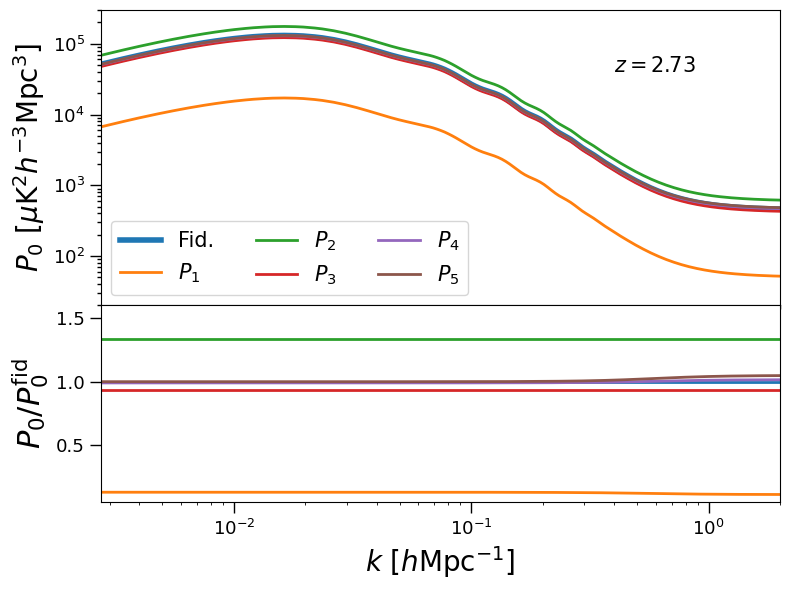

In [16]:
color = plt.rcParams['axes.prop_cycle'].by_key()['color']

f, ax = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 2],'hspace':0}, sharex='col',figsize=(8,6))
ax[0].loglog(kh,Pk,lw=4,label=r'Fid.')
ax[0].loglog(kh,Pk_alpha,label=r'$P_1$',lw=2)
ax[0].loglog(kh,Pk_beta,label=r'$P_2$',lw=2)
ax[0].loglog(kh,Pk_dMF,label=r'$P_3$',lw=2)
ax[0].loglog(kh,Pk_sig,label=r'$P_4$',lw=2)
ax[0].loglog(kh,Pk_scat,label=r'$P_5$',lw=2)
ax[0].set_ylabel(r'$P_0$ $[\mu{\rm K}^2h^{-3}{\rm Mpc}^3]$',fontsize=20)
ax[0].tick_params(axis='both',width=1,length=8,labelsize=13)
ax[0].tick_params(axis='both',which='minor',width=1,length=3)
ax[0].set_ylim(20,3e5)
ax[0].set_xlim(0.008,5)
ax[0].text(0.4,4e4,'$z=2.73$',fontsize=15)

ax[0].legend(fontsize=15,ncol=3,loc=3)


ax[1].semilogx(kh,Pk/Pk,lw=2)
ax[1].semilogx(kh,Pk_alpha/Pk,lw=2)
ax[1].semilogx(kh,Pk_beta/Pk,lw=2)
ax[1].semilogx(kh,Pk_dMF/Pk,lw=2)
ax[1].semilogx(kh,Pk_sig/Pk,lw=2)
ax[1].semilogx(kh,Pk_scat/Pk,lw=2)
ax[1].set_xlabel(r'$k$ [$h{\rm Mpc}^{-1}$]',fontsize=20)
ax[1].set_ylabel(r'$P_0/P_0^{\rm fid}$',fontsize=22)
ax[1].tick_params(axis='both',width=1,length=8,labelsize=13)
ax[1].set_xlim(kh[0].value,2)
ax[1].set_ylim(0.05,1.6)
#ax[1].loglog()
plt.tight_layout()
# plt.savefig('/Users/jlbernal/Dropbox/JoseLuis/PhD/RESEARCH/IM/Shared_Draft_CO/Figures/Pk_varL.pdf')

### Vary cosmo parameters

In [17]:
#Load survey specs
obs,NUOBS,DELTANU,dnu,freq,Tsys = survey_pars(survey='CCAT')

#Load fiducial model
fidmod = prepare_model(5,kkind='log',model='SilvaCII_15')


#get input parameters
INPUT = merge_dicts([fidmod,obs,dict(nuObs=NUOBS[0],Delta_nu=DELTANU[0],Tsys_NEFD=Tsys[0],dnu=dnu[0]),freq])
#Call lim
M = lim(INPUT)
M.update(kmin = M.kmin_field)
#Plot the true Pk
M.update(smooth=False)

#In case you want to limit the maximum k.
M.update(kmax = M.kmax_field)

#For frequency varying Tsys (set up for the IMS3 Tsys model)
if M.nuObs > 20.*u.GHz:
    M.update(Tsys_NEFD=M.nuObs/u.GHz*u.K)

#Obtain the fiducial IM Pk multipoles
vecparam = fiducial(M)
#We work in h/Mpc units
kh = M.k.to(M.Mpch**-1)
Pkclus, Pshot, kprime, muprime = Pk_AP(M,vecparam,smooth=False)
#To use same functions as for the derivatives, but M.Pk_0, M.Pk_2 and M.Pk_4 could have been used
P0,P2,P4 = get_multipoles(M,Pkclus, Pshot)

fact = vecparam[2]*0.05
vecparam[2] += fact 
Pkclus, Pshot, kprime, muprime = Pk_AP(M,vecparam,smooth=False)
Palphaperp,P2alphaperp,P4alphaperp = get_multipoles(M,Pkclus,Pshot) 
vecparam[2] -= fact

fact = vecparam[3]*0.05
vecparam[3] += fact 
Pkclus, Pshot, kprime, muprime = Pk_AP(M,vecparam,smooth=False)
Palphapar,P2alphapar,P4alphapar = get_multipoles(M,Pkclus,Pshot) 
vecparam[3] -= fact

fact = vecparam[4]*0.05
vecparam[4] += fact 
Pkclus, Pshot, kprime, muprime = Pk_AP(M,vecparam,smooth=False)
PTfs8,P2Tfs8,P4Tfs8 = get_multipoles(M,Pkclus,Pshot) 
vecparam[4] -= fact

fact = vecparam[5]*0.05
vecparam[5] += fact 
Pkclus, Pshot, kprime, muprime = Pk_AP(M,vecparam,smooth=False)
PTbs8,P2Tbs8,P4Tbs8 = get_multipoles(M,Pkclus,Pshot) 
vecparam[5] -= fact

fact = vecparam[6]*0.05
vecparam[6] += fact 
Pkclus, Pshot, kprime, muprime = Pk_AP(M,vecparam,smooth=False)
PsNL,P2sNL,P4sNL = get_multipoles(M,Pkclus,Pshot) 
vecparam[6] -= fact

fact = vecparam[7]*0.05
vecparam[7] += fact 
Pkclus, Pshot, kprime, muprime = Pk_AP(M,vecparam,smooth=False)
PT2mean,P2T2mean,P4T2mean = get_multipoles(M,Pkclus,Pshot) 
vecparam[7] -= fact

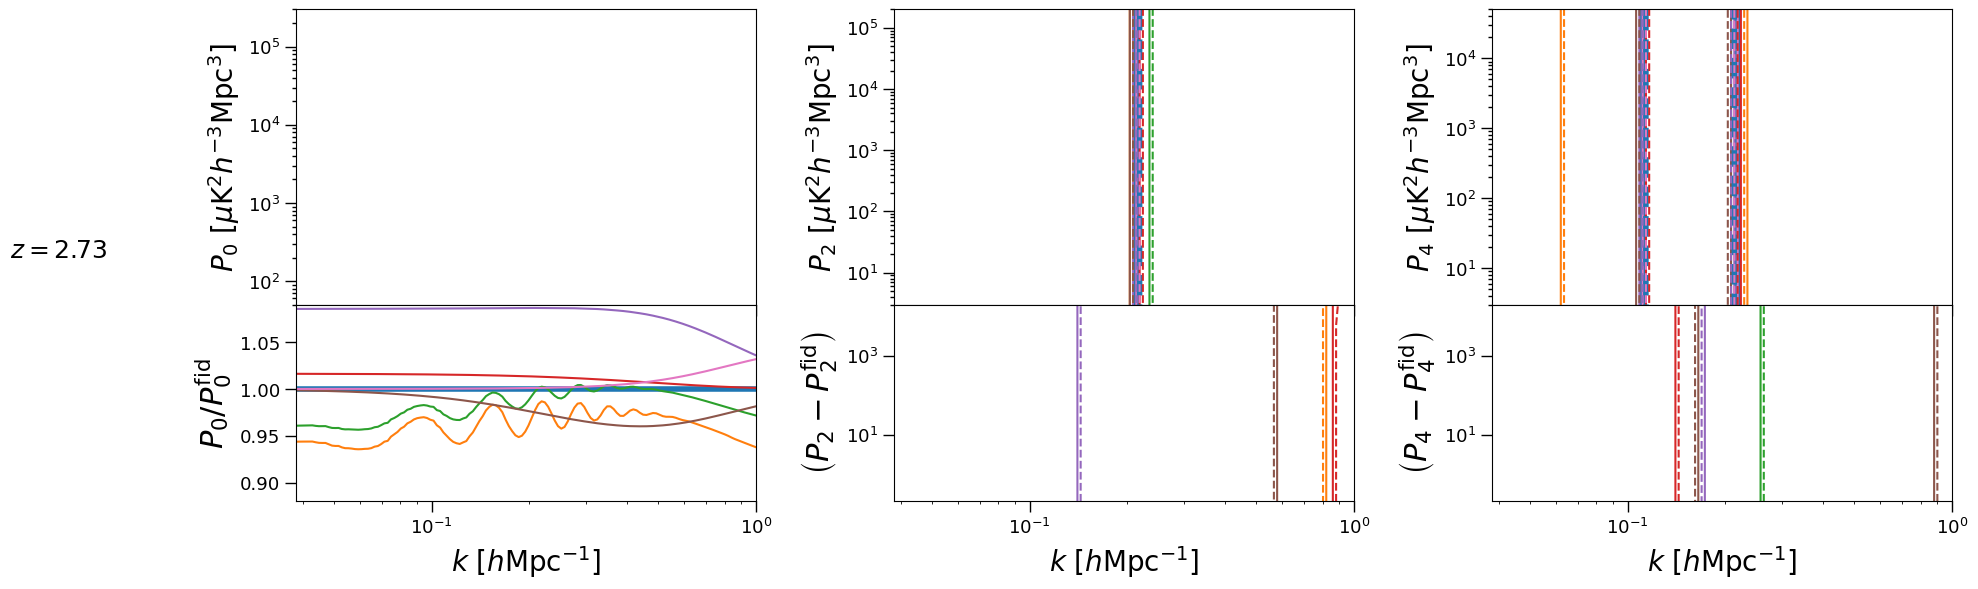

In [18]:
color = plt.rcParams['axes.prop_cycle'].by_key()['color']
gs = gridspec.GridSpec(2, 3,wspace=0.3,height_ratios=[3,2],hspace=0)

fig = plt.figure(figsize=(18,6))

ax = plt.subplot(gs[0,0])
ax.loglog(kh,P0,lw=4,label=r'Fid.')
ax.loglog(kh,Palphaperp,label=r'$\alpha_\perp$',lw=1.5)
ax.loglog(kh,Palphapar,label=r'$\alpha_\parallel$',lw=1.5)
ax.loglog(kh,PTfs8,label=r'$\langle T\rangle f\sigma_8$',lw=1.5)
ax.loglog(kh,PTbs8,label=r'$\langle T\rangle b\sigma_8$',lw=1.5)
ax.loglog(kh,PsNL,label=r'$\sigma_{FoG}$',lw=1.5)
ax.loglog(kh,PT2mean,label=r'$\langle T^2\rangle$',lw=1.5)
ax.set_ylabel(r'$P_0$ $[\mu{\rm K}^2h^{-3}{\rm Mpc}^3]$',fontsize=20)
ax.tick_params(axis='both',width=1,length=8,labelsize=13)
ax.tick_params(axis='both',which='minor',width=1,length=3)
ax.set_ylim(50,3e5)
ax.set_xlim(kh[0].value,1)
ax.text(0.005,2e2,'$z=2.73$',fontsize=18)
ax.set_xticklabels([])

ax = plt.subplot(gs[1,0])
ax.semilogx(kh,P0/P0,lw=4)
ax.semilogx(kh,Palphaperp/P0,lw=1.5)
ax.semilogx(kh,Palphapar/P0,lw=1.5)
ax.semilogx(kh,PTfs8/P0,lw=1.5)
ax.semilogx(kh,PTbs8/P0,lw=1.5)
ax.semilogx(kh,PsNL/P0,lw=1.5)
ax.semilogx(kh,PT2mean/P0,lw=1.5)
ax.set_xlabel(r'$k$ [$h{\rm Mpc}^{-1}$]',fontsize=20)
ax.set_ylabel(r'$P_0/P_0^{\rm fid}$',fontsize=22)
ax.tick_params(axis='both',width=1,length=8,labelsize=13)
ax.set_xlim(kh[0].value,1)
ax.set_ylim(0.88,1.09)

##########

ax = plt.subplot(gs[0,1])
ax.loglog(kh,P2,lw=4,label=r'Fid.')
ax.loglog(kh,P2alphaperp,label=r'$\alpha_\perp$',lw=1.5)
ax.loglog(kh,P2alphapar,label=r'$\alpha_\parallel$',lw=1.5)
ax.loglog(kh,P2Tfs8,label=r'$\langle T\rangle f\sigma_8$',lw=1.5)
ax.loglog(kh,P2Tbs8,label=r'$\langle T\rangle b\sigma_8$',lw=1.5)
ax.loglog(kh,P2sNL,label=r'$\sigma_{FoG}$',lw=1.5)
ax.loglog(kh,P2T2mean,label=r'$\langle T^2\rangle$',lw=1.5)
#plot also the negative Pk
ax.loglog(kh,-P2,lw=4,label=r'Fid.',color=color[0],ls='--')
ax.loglog(kh,-P2alphaperp,label=r'$\alpha_\perp$',lw=1.5,color=color[1],ls='--')
ax.loglog(kh,-P2alphapar,label=r'$\alpha_\parallel$',lw=1.5,color=color[2],ls='--')
ax.loglog(kh,-P2Tfs8,label=r'$\langle T\rangle f\sigma_8$',lw=1.5,color=color[3],ls='--')
ax.loglog(kh,-P2Tbs8,label=r'$\langle T\rangle b\sigma_8$',lw=1.5,color=color[4],ls='--')
ax.loglog(kh,-P2sNL,label=r'$\sigma_{FoG}$',lw=1.5,color=color[5],ls='--')
ax.loglog(kh,-P2T2mean,label=r'$\langle T^2\rangle$',lw=1.5,color=color[6],ls='--')
ax.set_ylabel(r'$P_2$ $[\mu{\rm K}^2h^{-3}{\rm Mpc}^3]$',fontsize=20)
ax.tick_params(axis='both',width=1,length=8,labelsize=13)
ax.tick_params(axis='both',which='minor',width=1,length=3)
ax.set_ylim(3,2e5)
ax.set_xlim(kh[0].value,1)
ax.set_xticklabels([])

ax = plt.subplot(gs[1,1])
ax.loglog(kh,(P2-P2),lw=4)
ax.loglog(kh,(P2alphaperp-P2),lw=1.5)
ax.loglog(kh,(P2alphapar-P2),lw=1.5)
ax.loglog(kh,(P2Tfs8-P2),lw=1.5)
ax.loglog(kh,(P2Tbs8-P2),lw=1.5)
ax.loglog(kh,(P2sNL-P2),lw=1.5)
ax.loglog(kh,(P2T2mean-P2),lw=1.5)
#plot also the negative Pk
#ax.loglog(kh,(P2-P2),lw=4)
ax.loglog(kh,-(P2alphaperp-P2),lw=1.5,color=color[1],ls='--')
ax.loglog(kh,-(P2alphapar-P2),lw=1.5,color=color[2],ls='--')
ax.loglog(kh,-(P2Tfs8-P2),lw=1.5,color=color[3],ls='--')
ax.loglog(kh,-(P2Tbs8-P2),lw=1.5,color=color[4],ls='--')
ax.loglog(kh,-(P2sNL-P2),lw=1.5,color=color[5],ls='--')
#ax.loglog(kh,-(P2T2mean-P2),lw=1.5,color=color[6],ls='--')
ax.set_xlabel(r'$k$ [$h{\rm Mpc}^{-1}$]',fontsize=20)
ax.set_ylabel(r'$\left(P_2-P_2^{\rm fid}\right)$',fontsize=22)
ax.tick_params(axis='both',width=1,length=8,labelsize=13)
ax.set_xlim(kh[0].value,1)
ax.set_ylim(2e-1,2e4)

##########

ax = plt.subplot(gs[0,2])
ax.loglog(kh,P4,lw=4,label=r'Fid.')
ax.loglog(kh,P4alphaperp,label=r'$\alpha_\perp$',lw=1.5)
ax.loglog(kh,P4alphapar,label=r'$\alpha_\parallel$',lw=1.5)
ax.loglog(kh,P4Tfs8,label=r'$\langle T\rangle f\sigma_8$',lw=1.5)
ax.loglog(kh,P4Tbs8,label=r'$\langle T\rangle b\sigma_8$',lw=1.5)
ax.loglog(kh,P4sNL,label=r'$\sigma_{FoG}$',lw=1.5)
ax.loglog(kh,P4T2mean,label=r'$\langle T^2\rangle$',lw=1.5)
#plot also the negative Pk
ax.loglog(kh,-P4,lw=4,label=r'Fid.',color=color[0],ls='--')
ax.loglog(kh,-P4alphaperp,label=r'$\alpha_\perp$',lw=1.5,color=color[1],ls='--')
ax.loglog(kh,-P4alphapar,label=r'$\alpha_\parallel$',lw=1.5,color=color[2],ls='--')
ax.loglog(kh,-P4Tfs8,label=r'$\langle T\rangle f\sigma_8$',lw=1.5,color=color[3],ls='--')
ax.loglog(kh,-P4Tbs8,label=r'$\langle T\rangle b\sigma_8$',lw=1.5,color=color[4],ls='--')
ax.loglog(kh,-P4sNL,label=r'$\sigma_{FoG}$',lw=1.5,color=color[5],ls='--')
ax.loglog(kh,-P4T2mean,label=r'$\langle T^2\rangle$',lw=1.5,color=color[6],ls='--')
ax.set_ylabel(r'$P_4$ $[\mu{\rm K}^2h^{-3}{\rm Mpc}^3]$',fontsize=20)
ax.tick_params(axis='both',width=1,length=8,labelsize=13)
ax.tick_params(axis='both',which='minor',width=1,length=3)
ax.set_ylim(3,5e4)
ax.set_xlim(kh[0].value,1)
ax.set_xticklabels([])

ax = plt.subplot(gs[1,2])
ax.loglog(kh,(P4-P4),lw=4)
ax.loglog(kh,(P4alphaperp-P4),lw=1.5)
ax.loglog(kh,(P4alphapar-P4),lw=1.5)
ax.loglog(kh,(P4Tfs8-P4),lw=1.5)
ax.loglog(kh,(P4Tbs8-P4),lw=1.5)
ax.loglog(kh,(P4sNL-P4),lw=1.5)
ax.loglog(kh,(P4T2mean-P4),lw=1.5)
#plot also the negative Pk
#ax.loglog(kh,(P4-P4),lw=4)
ax.loglog(kh,-(P4alphaperp-P4),lw=1.5,color=color[1],ls='--')
ax.loglog(kh,-(P4alphapar-P4),lw=1.5,color=color[2],ls='--')
ax.loglog(kh,-(P4Tfs8-P4),lw=1.5,color=color[3],ls='--')
ax.loglog(kh,-(P4Tbs8-P4),lw=1.5,color=color[4],ls='--')
ax.loglog(kh,-(P4sNL-P4),lw=1.5,color=color[5],ls='--')
#ax.loglog(kh,-(P4T2mean-P4),lw=1.5,color=color[6],ls='--')
ax.set_xlabel(r'$k$ [$h{\rm Mpc}^{-1}$]',fontsize=20)
ax.set_ylabel(r'$\left(P_4-P_4^{\rm fid}\right)$',fontsize=22)
ax.tick_params(axis='both',width=1,length=8,labelsize=13)
ax.set_xlim(kh[0].value,1)
ax.set_ylim(2e-1,2e4)

plt.subplots_adjust(hspace=0)
plt.subplots_adjust(top=0.98)
plt.subplots_adjust(left=0.06)
plt.subplots_adjust(bottom=0.16)
plt.subplots_adjust(right=0.98)

#plt.tight_layout()
# plt.savefig('/Users/jlbernal/Dropbox/JoseLuis/PhD/RESEARCH/IM/Shared_Draft_CO/Figures/Pk_varcosmo.pdf')

In [19]:
#Load survey specs
obs,NUOBS,DELTANU,dnu,freq,Tsys = survey_pars(survey='CCAT')

#Load fiducial model
fidmod = prepare_model(5,kkind='log',model='SilvaCII_15')


#get input parameters
INPUT = merge_dicts([fidmod,obs,dict(nuObs=NUOBS[0],Delta_nu=DELTANU[0],Tsys_NEFD=Tsys[0],dnu=dnu[0]),freq])
#Call lim
M = lim(INPUT)
M.update(kmin = M.kmin_field)
#Plot the smoothed Pk
M.update(smooth=True)

#In case you want to limit the maximum k.
M.update(kmax = M.kmax_field)

#For frequency varying Tsys (set up for the IMS3 Tsys model)
if M.nuObs > 20.*u.GHz:
    M.update(Tsys_NEFD=M.nuObs/u.GHz*u.K)

#Obtain the fiducial IM Pk multipoles
vecparam = fiducial(M)
#We work in h/Mpc units
kh = M.k.to(M.Mpch**-1)
Pkclus, Pshot, kprime, muprime = Pk_AP(M,vecparam,smooth=True)
#To use same functions as for the derivatives, but M.Pk_0, M.Pk_2 and M.Pk_4 could have been used
P0,P2,P4 = get_multipoles(M,Pkclus, Pshot)

fact = vecparam[2]*0.05
vecparam[2] += fact 
Pkclus, Pshot, kprime, muprime = Pk_AP(M,vecparam,smooth=True)
Palphaperp,P2alphaperp,P4alphaperp = get_multipoles(M,Pkclus,Pshot) 
vecparam[2] -= fact

fact = vecparam[3]*0.05
vecparam[3] += fact 
Pkclus, Pshot, kprime, muprime = Pk_AP(M,vecparam,smooth=True)
Palphapar,P2alphapar,P4alphapar = get_multipoles(M,Pkclus,Pshot) 
vecparam[3] -= fact

fact = vecparam[4]*0.05
vecparam[4] += fact 
Pkclus, Pshot, kprime, muprime = Pk_AP(M,vecparam,smooth=True)
PTfs8,P2Tfs8,P4Tfs8 = get_multipoles(M,Pkclus,Pshot) 
vecparam[4] -= fact

fact = vecparam[5]*0.05
vecparam[5] += fact 
Pkclus, Pshot, kprime, muprime = Pk_AP(M,vecparam,smooth=True)
PTbs8,P2Tbs8,P4Tbs8 = get_multipoles(M,Pkclus,Pshot) 
vecparam[5] -= fact

fact = vecparam[6]*0.05
vecparam[6] += fact 
Pkclus, Pshot, kprime, muprime = Pk_AP(M,vecparam,smooth=True)
PsNL,P2sNL,P4sNL = get_multipoles(M,Pkclus,Pshot) 
vecparam[6] -= fact

fact = vecparam[7]*0.05
vecparam[7] += fact 
Pkclus, Pshot, kprime, muprime = Pk_AP(M,vecparam,smooth=True)
PT2mean,P2T2mean,P4T2mean = get_multipoles(M,Pkclus,Pshot) 
vecparam[7] -= fact

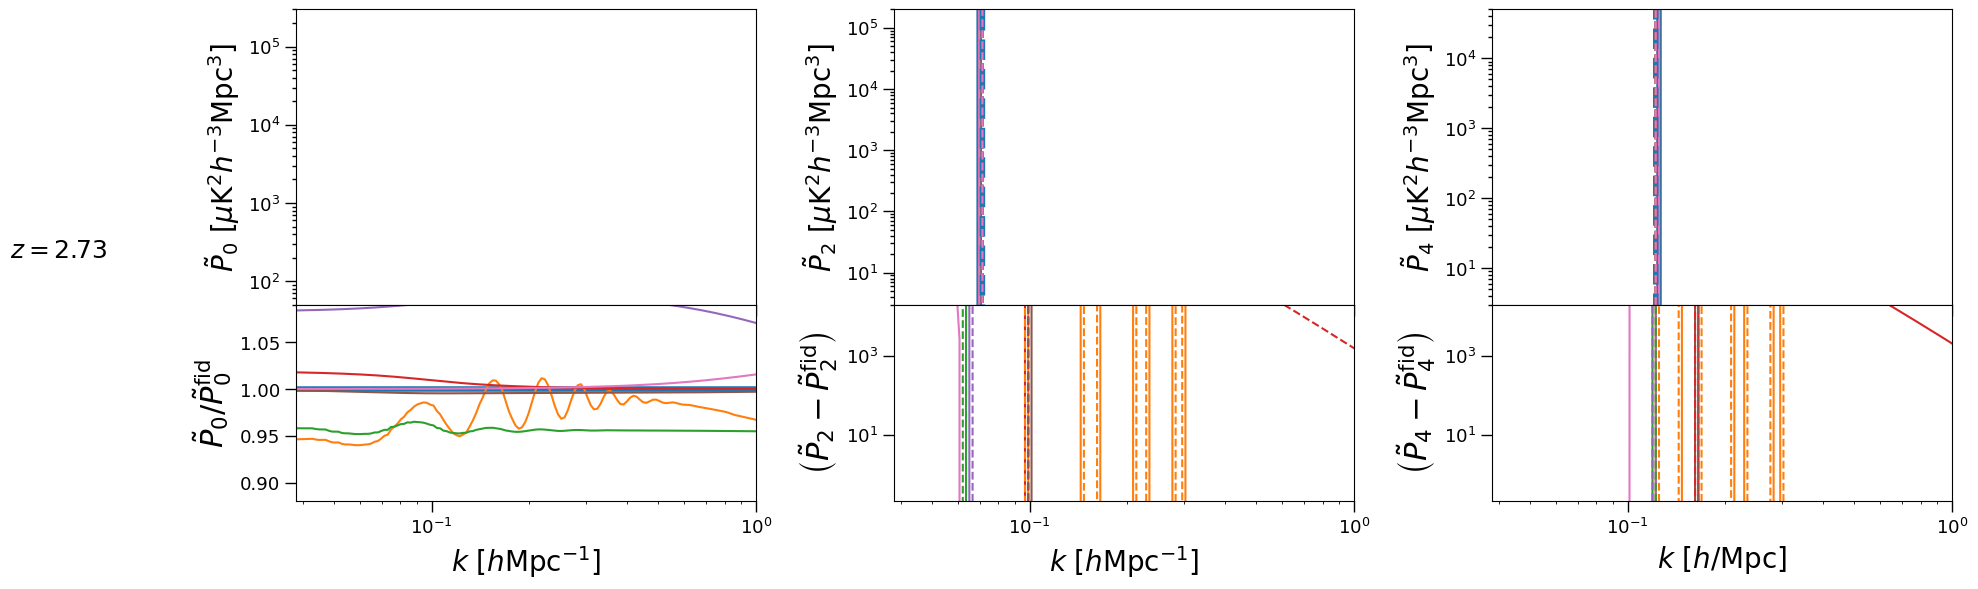

In [20]:
color = plt.rcParams['axes.prop_cycle'].by_key()['color']
gs = gridspec.GridSpec(2, 3,wspace=0.3,height_ratios=[3,2],hspace=0)

fig = plt.figure(figsize=(18,6))

ax = plt.subplot(gs[0,0])
ax.loglog(kh,P0,lw=4,label=r'Fid.')
ax.loglog(kh,Palphaperp,label=r'$\alpha_\perp$',lw=1.5)
ax.loglog(kh,Palphapar,label=r'$\alpha_\parallel$',lw=1.5)
ax.loglog(kh,PTfs8,label=r'$\langle T\rangle f\sigma_8$',lw=1.5)
ax.loglog(kh,PTbs8,label=r'$\langle T\rangle b\sigma_8$',lw=1.5)
ax.loglog(kh,PsNL,label=r'$\sigma_{FoG}$',lw=1.5)
ax.loglog(kh,PT2mean,label=r'$\langle T^2\rangle$',lw=1.5)
ax.set_ylabel(r'$\tilde{P}_0$ $[\mu{\rm K}^2h^{-3}{\rm Mpc}^3]$',fontsize=20)
ax.tick_params(axis='both',width=1,length=8,labelsize=13)
ax.tick_params(axis='both',which='minor',width=1,length=3)
ax.set_ylim(50,3e5)
ax.set_xlim(kh[0].value,1)
ax.text(0.005,2e2,'$z=2.73$',fontsize=18)
ax.set_xticklabels([])

ax = plt.subplot(gs[1,0])
ax.semilogx(kh,P0/P0,lw=4)
ax.semilogx(kh,Palphaperp/P0,lw=1.5)
ax.semilogx(kh,Palphapar/P0,lw=1.5)
ax.semilogx(kh,PTfs8/P0,lw=1.5)
ax.semilogx(kh,PTbs8/P0,lw=1.5)
ax.semilogx(kh,PsNL/P0,lw=1.5)
ax.semilogx(kh,PT2mean/P0,lw=1.5)
ax.set_xlabel(r'$k$ [$h{\rm Mpc}^{-1}$]',fontsize=20)
ax.set_ylabel(r'$\tilde{P}_0/\tilde{P}_0^{\rm fid}$',fontsize=22)
ax.tick_params(axis='both',width=1,length=8,labelsize=13)
ax.set_xlim(kh[0].value,1)
ax.set_ylim(0.88,1.09)
##########

ax = plt.subplot(gs[0,1])
ax.loglog(kh,P2,lw=4,label=r'Fid.')
ax.loglog(kh,P2alphaperp,label=r'$\alpha_\perp$',lw=1.5)
ax.loglog(kh,P2alphapar,label=r'$\alpha_\parallel$',lw=1.5)
ax.loglog(kh,P2Tfs8,label=r'$\langle T\rangle f\sigma_8$',lw=1.5)
ax.loglog(kh,P2Tbs8,label=r'$\langle T\rangle b\sigma_8$',lw=1.5)
ax.loglog(kh,P2sNL,label=r'$\sigma_{FoG}$',lw=1.5)
ax.loglog(kh,P2T2mean,label=r'$\langle T^2\rangle$',lw=1.5)
#plot also the negative Pk
ax.loglog(kh,-P2,lw=4,label=r'Fid.',color=color[0],ls='--')
ax.loglog(kh,-P2alphaperp,label=r'$\alpha_\perp$',lw=1.5,color=color[1],ls='--')
ax.loglog(kh,-P2alphapar,label=r'$\alpha_\parallel$',lw=1.5,color=color[2],ls='--')
ax.loglog(kh,-P2Tfs8,label=r'$\langle T\rangle f\sigma_8$',lw=1.5,color=color[3],ls='--')
ax.loglog(kh,-P2Tbs8,label=r'$\langle T\rangle b\sigma_8$',lw=1.5,color=color[4],ls='--')
ax.loglog(kh,-P2sNL,label=r'$\sigma_{FoG}$',lw=1.5,color=color[5],ls='--')
ax.loglog(kh,-P2T2mean,label=r'$\langle T^2\rangle$',lw=1.5,color=color[6],ls='--')
ax.set_ylabel(r'$\tilde{P}_2$ $[\mu{\rm K}^2h^{-3}{\rm Mpc}^3]$',fontsize=20)
ax.tick_params(axis='both',width=1,length=8,labelsize=13)
ax.tick_params(axis='both',which='minor',width=1,length=3)
ax.set_ylim(3,2e5)
ax.set_xlim(kh[0].value,1)
ax.set_xticklabels([])

ax = plt.subplot(gs[1,1])
ax.loglog(kh,(P2-P2),lw=4)
ax.loglog(kh,(P2alphaperp-P2),lw=1.5)
ax.loglog(kh,(P2alphapar-P2),lw=1.5)
ax.loglog(kh,(P2Tfs8-P2),lw=1.5)
ax.loglog(kh,(P2Tbs8-P2),lw=1.5)
ax.loglog(kh,(P2sNL-P2),lw=1.5)
ax.loglog(kh,(P2T2mean-P2),lw=1.5)
#plot also the negative Pk
#ax.loglog(kh,(P2-P2),lw=4)
ax.loglog(kh,-(P2alphaperp-P2),lw=1.5,color=color[1],ls='--')
ax.loglog(kh,-(P2alphapar-P2),lw=1.5,color=color[2],ls='--')
ax.loglog(kh,-(P2Tfs8-P2),lw=1.5,color=color[3],ls='--')
ax.loglog(kh,-(P2Tbs8-P2),lw=1.5,color=color[4],ls='--')
ax.loglog(kh,-(P2sNL-P2),lw=1.5,color=color[5],ls='--')
#ax.loglog(kh,-(P2T2mean-P2),lw=1.5,color=color[6],ls='--')
ax.set_xlabel(r'$k$ [$h{\rm Mpc}^{-1}$]',fontsize=20)
ax.set_ylabel(r'$\left(\tilde{P}_2-\tilde{P}_2^{\rm fid}\right)$',fontsize=22)
ax.tick_params(axis='both',width=1,length=8,labelsize=13)
ax.set_xlim(kh[0].value,1)
ax.set_ylim(2e-1,2e4)

##########

ax = plt.subplot(gs[0,2])
ax.loglog(kh,P4,lw=4,label=r'Fid.')
ax.loglog(kh,P4alphaperp,label=r'$\alpha_\perp$',lw=1.5)
ax.loglog(kh,P4alphapar,label=r'$\alpha_\parallel$',lw=1.5)
ax.loglog(kh,P4Tfs8,label=r'$\langle T\rangle f\sigma_8$',lw=1.5)
ax.loglog(kh,P4Tbs8,label=r'$\langle T\rangle b\sigma_8$',lw=1.5)
ax.loglog(kh,P4sNL,label=r'$\sigma_{FoG}$',lw=1.5)
ax.loglog(kh,P4T2mean,label=r'$\langle T^2\rangle$',lw=1.5)
#plot also the negative Pk
ax.loglog(kh,-P4,lw=4,label=r'Fid.',color=color[0],ls='--')
ax.loglog(kh,-P4alphaperp,label=r'$\alpha_\perp$',lw=1.5,color=color[1],ls='--')
ax.loglog(kh,-P4alphapar,label=r'$\alpha_\parallel$',lw=1.5,color=color[2],ls='--')
ax.loglog(kh,-P4Tfs8,label=r'$\langle T\rangle f\sigma_8$',lw=1.5,color=color[3],ls='--')
ax.loglog(kh,-P4Tbs8,label=r'$\langle T\rangle b\sigma_8$',lw=1.5,color=color[4],ls='--')
ax.loglog(kh,-P4sNL,label=r'$\sigma_{FoG}$',lw=1.5,color=color[5],ls='--')
ax.loglog(kh,-P4T2mean,label=r'$\langle T^2\rangle$',lw=1.5,color=color[6],ls='--')
ax.set_ylabel(r'$\tilde{P}_4$ $[\mu{\rm K}^2h^{-3}{\rm Mpc}^3]$',fontsize=20)
ax.tick_params(axis='both',width=1,length=8,labelsize=13)
ax.tick_params(axis='both',which='minor',width=1,length=3)
ax.set_ylim(3,5e4)
ax.set_xlim(kh[0].value,1)
ax.set_xticklabels([])

ax = plt.subplot(gs[1,2])
ax.loglog(kh,(P4-P4),lw=4)
ax.loglog(kh,(P4alphaperp-P4),lw=1.5)
ax.loglog(kh,(P4alphapar-P4),lw=1.5)
ax.loglog(kh,(P4Tfs8-P4),lw=1.5)
ax.loglog(kh,(P4Tbs8-P4),lw=1.5)
ax.loglog(kh,(P4sNL-P4),lw=1.5)
ax.loglog(kh,(P4T2mean-P2),lw=1.5)
ax.set_xlabel(r'$k$ [$h/{\rm Mpc}$]',fontsize=20)
ax.set_ylabel(r'$\left(\tilde{P}_4-\tilde{P}_4^{\rm fid}\right)$',fontsize=22)
#plot also the negative Pk
#ax.loglog(kh,(P4-P4),lw=4)
ax.loglog(kh,-(P4alphaperp-P4),lw=1.5,color=color[1],ls='--')
ax.loglog(kh,-(P4alphapar-P4),lw=1.5,color=color[2],ls='--')
ax.loglog(kh,-(P4Tfs8-P4),lw=1.5,color=color[3],ls='--')
ax.loglog(kh,-(P4Tbs8-P4),lw=1.5,color=color[4],ls='--')
ax.loglog(kh,-(P4sNL-P4),lw=1.5,color=color[5],ls='--')
#ax.loglog(kh,-(P4T2mean-P4),lw=1.5,color=color[6],ls='--')
ax.tick_params(axis='both',width=1,length=8,labelsize=13)
ax.set_xlim(kh[0].value,1)
ax.set_ylim(2e-1,2e4)

plt.subplots_adjust(hspace=0)
plt.subplots_adjust(top=0.98)
plt.subplots_adjust(left=0.06)
plt.subplots_adjust(bottom=0.16)
plt.subplots_adjust(right=0.98)

#plt.tight_layout()
# plt.savefig('/Users/jlbernal/Dropbox/JoseLuis/PhD/RESEARCH/IM/Shared_Draft_CO/Figures/Pk_varcosmo_smoothed.pdf')

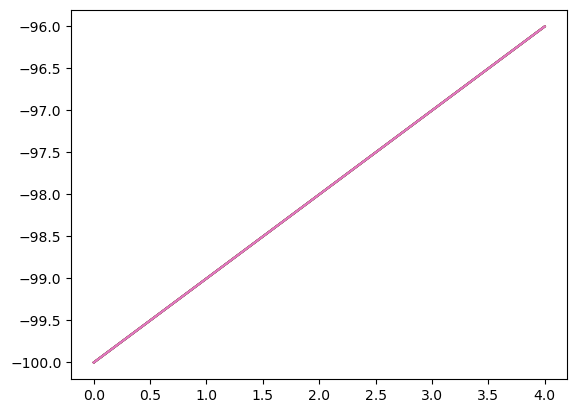

(0.0, 1.0, 0.0, 1.0)

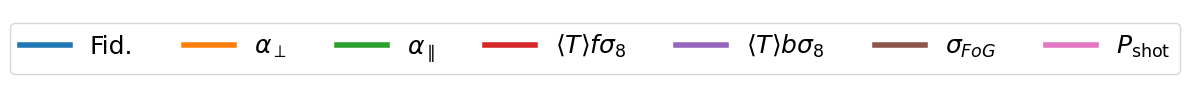

In [21]:
yy = np.linspace(0,4,10)
a, = plt.plot(yy,yy-100,color=color[0])
b, = plt.plot(yy,yy-100,color=color[1])
c, = plt.plot(yy,yy-100,color=color[2])
d, = plt.plot(yy,yy-100,color=color[3])
e, = plt.plot(yy,yy-100,color=color[4])
f, = plt.plot(yy,yy-100,color=color[5])
g, = plt.plot(yy,yy-100,color=color[6])
plt.show()
fig = plt.figure(figsize=(13,1))

leg = fig.legend((a,b,c,d,e,f,g),(r'Fid.',r'$\alpha_\perp$',r'$\alpha_\parallel$',r'$\langle T\rangle f\sigma_8$',
                                 r'$\langle T\rangle b\sigma_8$',r'$\sigma_{FoG}$',r'$P_{\rm shot}$'), 
                 loc='center',
           ncol=7, borderaxespad=0.,fontsize=18)
for l in leg.get_lines():
    l.set_linewidth(4.)

plt.axis('off')
# plt.savefig('/Users/jlbernal/Dropbox/JoseLuis/PhD/RESEARCH/IM/Shared_Draft_CO/Figures/Pkvarcosmo_legend.pdf')

### BAO & RSD measurements

In [22]:
#Get the constraints from the fisher matrices computed above
sigma_alpha_par_ims3 = np.zeros(5)
sigma_alpha_perp_ims3 = np.zeros(5)
sigma_Tfs8_ims3 = np.zeros(5)
sigma_fs8_ims3_100 = np.zeros(5)
sigma_fs8_ims3_20 = np.zeros(5)
sigma_fs8_ims3_10 = np.zeros(5)

for i in range(5):
    z,sigma= get_bao_Tfs8_constraints(fisher_ims3,'IMS3',i)
    
    sigma_Tfs8_ims3[i] = sigma[2]
    sigma_alpha_par_ims3[i] = sigma[1]
    sigma_alpha_perp_ims3[i] = sigma[0]
    
z_ims3 = z

z_comap,sigma_comap = get_bao_Tfs8_constraints(fisher_comap2,'COMAP_2',0)
sigma_alpha_par_comap = sigma_comap[1]
sigma_alpha_perp_comap = sigma_comap[0]
sigma_Tfs8_comap = sigma_comap[2]

z_comap1,sigma_comap1 = get_bao_Tfs8_constraints(fisher_comap1,'COMAP_1',0)
sigma_alpha_par_comap1 = sigma_comap1[1]
sigma_alpha_perp_comap1 = sigma_comap1[0]
sigma_Tfs8_comap1 = sigma_comap1[2]

sigma_alpha_par_sxdeep_halpha = np.zeros(4)
sigma_alpha_perp_sxdeep_halpha = np.zeros(4)
sigma_Tfs8_sxdeep_halpha = np.zeros(4)
sigma_fs8_sxdeep_20_halpha = np.zeros(4)

for i in range(4):
    z,sigma= get_bao_Tfs8_constraints(fisher_spherexdeep_Halpha,'SPHEREx_deep_Halpha',i)
    sigma_Tfs8_sxdeep_halpha[i] = sigma[2]
    sigma_alpha_par_sxdeep_halpha[i] = sigma[1]
    sigma_alpha_perp_sxdeep_halpha[i] = sigma[0]
        
zsx_halpha = z

sigma_alpha_par_sxdeep_lyalpha = np.zeros(3)
sigma_alpha_perp_sxdeep_lyalpha = np.zeros(3)
sigma_Tfs8_sxdeep_lyalpha = np.zeros(3)
sigma_fs8_sxdeep_20_lyalpha = np.zeros(3)
for i in range(3):
    z,sigma= get_bao_Tfs8_constraints(fisher_spherexdeep_Lymanalpha,'SPHEREx_deep_Lyalpha',i)
    sigma_Tfs8_sxdeep_lyalpha[i] = sigma[2]
    sigma_alpha_par_sxdeep_lyalpha[i] = sigma[1]
    sigma_alpha_perp_sxdeep_lyalpha[i] = sigma[0]
        
zsx_lyalpha = z

sigma_alpha_par_CCAT_cii = np.zeros(4)
sigma_alpha_perp_CCAT_cii = np.zeros(4)
sigma_Tfs8_CCAT_cii = np.zeros(4)
sigma_fs8_cii_CCAT_cii = np.zeros(4)
for i in range(4):
    z,sigma= get_bao_Tfs8_constraints(fisher_CCAT_cii,'CCAT',i)
    sigma_Tfs8_CCAT_cii[i] = sigma[2]
    sigma_alpha_par_CCAT_cii[i] = sigma[1]
    sigma_alpha_perp_CCAT_cii[i] = sigma[0]
        
zcii_CCAT = z

sigma_alpha_par_cii_stageii = np.zeros(2)
sigma_alpha_perp_cii_stageii = np.zeros(2)
sigma_Tfs8_cii_stageii = np.zeros(2)
sigma_fs8_cii_stageii = np.zeros(2)
for i in range(2):
    z,sigma= get_bao_Tfs8_constraints(fisher_cii_stageii,'CII_stageII',i)
    sigma_Tfs8_cii_stageii[i] = sigma[2]
    sigma_alpha_par_cii_stageii[i] = sigma[1]
    sigma_alpha_perp_cii_stageii[i] = sigma[0]
        
zcii_stageii = z

In [23]:
#Compute the prediction for the LCDM fiducial model

M=lim()

omega_b = 0.0224218
omega_cdm = 0.119328
H0 = 67.6637
ns = 0.96649
logA = 3.0466
fNL = 0
mnu = 0.06

M.update(cosmo_input={'H0':H0,'ombh2':omega_b,'omch2':omega_cdm,
                              'As':np.exp(logA)*1e-10,'f_NL':fNL,'ns':ns,'mnu':mnu})

zlin = np.linspace(0,10,640)
DAlin = M.cosmo.angular_diameter_distance(zlin)
DAint = i1d(zlin,DAlin)
Hlin = M.cosmo.hubble_parameter(zlin)
Hint = i1d(zlin,Hlin)

zint = np.linspace(0,10,512)
zlin_fs8 = np.linspace(0,10,32) 
M.camb_pars.set_matter_power(redshifts=list(zlin_fs8), 
                                        kmax=.1)
cosmo = camb.get_results(M.camb_pars)
fs8lin = cosmo.get_fsigma8()
bs8lin = cosmo.get_sigma8()
fs8int = i1d(zlin_fs8[::-1],fs8lin,kind='cubic')
bs8int = i1d(zlin_fs8[::-1],bs8lin,kind='cubic')

Note: redshifts have been re-sorted (earliest first)


In [24]:
#Input the existing and forecasted measurements for galaxy surveys

#First you need the fiducial rs for our model
BAO_pars = M.cosmo.get_BAO([M.z],M.camb_pars)
#This is rs/DV, H, DA, F_AP
DV = (M.cosmo.comoving_radial_distance(M.z)**2*
            cu.c.to(u.km/u.s).value*M.z/M.H.value)**(1./3.)
rs = BAO_pars[0,0]*DV

####
z_bossdr12 = np.array([0.38,0.51,0.61])
DA_bossdr12 = np.array([1518.36,1997.44,2283.18])/(1.+z_bossdr12)*147.78/rs
sigma_DA_bossdr12 = np.array([22.36,26.5,31.89])/(1.+z_bossdr12)*147.78/rs
H_bossdr12 = np.array([81.5095,90.4474,97.2556])/147.78*rs
sigma_H_bossdr12 = np.array([1.9,1.94,2.1])/147.78*rs
sigma_fs8_bossdr12 = np.array([0.045,0.038,0.034])
z_bossdr14_Lya = np.array([2.34,2.35])
H_bossdr14_Lya = np.array([cu.c.to(u.km/u.s).value/8.86,cu.c.to(u.km/u.s).value/9.20])/rs#149.7
sigma_H_bossdr14_Lya = np.array([cu.c.to(u.km/u.s).value/8.86**2*0.36,
                                 cu.c.to(u.km/u.s).value/9.20**2*0.29])/rs#149.7*0.22
DA_bossdr14_Lya = np.array([37.41/3.34,36.3/3.35])*rs
sigma_DA_bossdr14_Lya = np.array([1.86/3.34,1.8/3.35])*rs
###
z_eboss = np.array([1.52])
DA_eboss = np.array([1850.])/rs*147.78
sigma_DA_eboss = np.array([110.])/rs*147.78
H_eboss = np.array([162.])/147.78*rs
sigma_H_eboss = np.array([12.])/147.78*rs
###
z_desi = np.arange(0.65,1.86,0.1)
z_desi_Lya = np.array([1.96,2.12,2.28,2.43,2.59,2.75,2.91,
                     3.07,3.23,3.39,3.55])
sigma_DA_desi = np.array([0.82,0.69,0.69,0.73,0.89,0.94,0.96,
                     1.50,1.59,1.90,2.88,4.64,4.71])*1e-2
sigma_H_desi = np.array([1.5,1.27,1.22,1.22,1.37,1.39,1.39,
                     2.02,2.13,2.52,3.80,6.30,6.39])*1e-2
sigma_DA_desi_Lya = np.array([2.69,1.95,2.18,2.46,2.86,
                         3.40,4.21,5.29,7.10,10.46,15.91])*1e-2
sigma_H_desi_Lya = np.array([2.74,1.99,2.11,2.26,2.47,
                        2.76,3.18,3.70,4.57,6.19,8.89])*1e-2
z_desi_bgs = np.array([0.05,0.15,0.25,0.35,0.45])
sigma_DA_desi_bgs = np.array([6.12,2.35,1.51,1.32,2.39])*1e-2
sigma_H_desi_bgs = np.array([12.10,4.66,2.97,2.44,3.69])*1e-2



(0.85, 1.15)

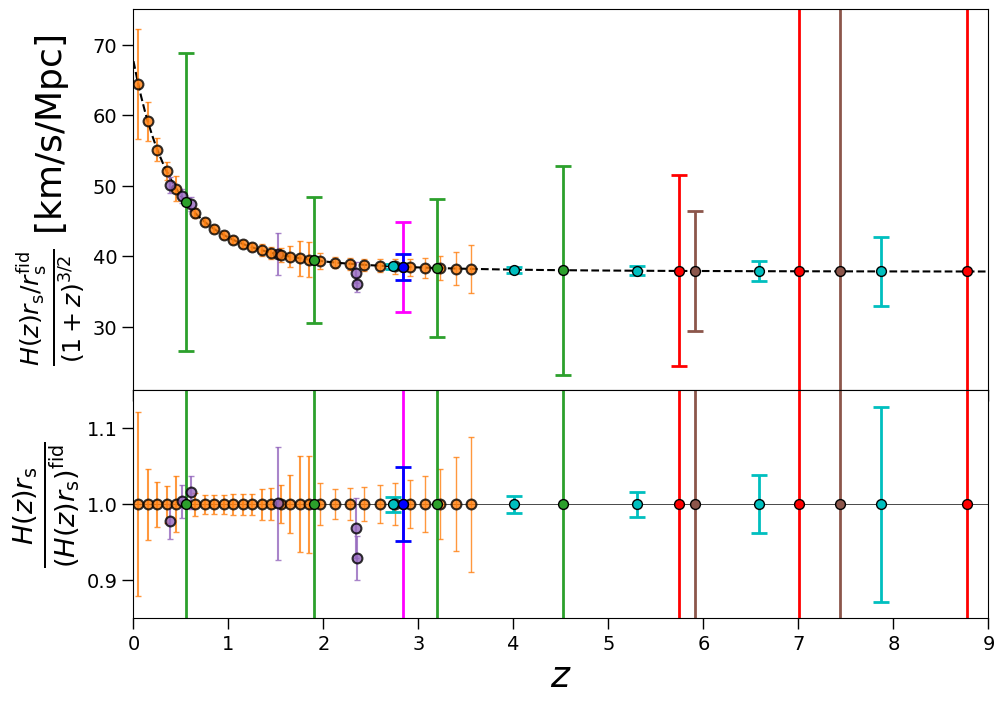

In [41]:
#H(z) plot

color = plt.rcParams['axes.prop_cycle'].by_key()['color']
f, ax = plt.subplots(2,1, gridspec_kw = {'hspace':0,'height_ratios':[5,3],'top':.98,'right':.98}, sharex='col',figsize=(10,7))

#H(z)
ax[0].plot(zint,Hint(zint)/(1+zint)**1.5,lw=1.5,c='k',zorder=0,ls='--')
ax[0].errorbar(z_eboss,H_eboss/(1+z_eboss)**1.5,yerr=sigma_H_eboss/(1+z_eboss)**1.5,capsize=2,capthick=1,color=color[4],zorder=2,ls='',alpha=0.8)
ax[0].scatter(z_eboss,H_eboss/(1+z_eboss)**1.5,color=color[4],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,label='BOSS/eBOSS',alpha=0.8)
ax[0].errorbar(z_desi,Hint(z_desi)/(1+z_desi)**1.5,yerr=sigma_H_desi*Hint(z_desi)/(1+z_desi)**1.5,capsize=2,capthick=1,color=color[1],zorder=1,ls='',alpha=0.8)
ax[0].errorbar(z_desi_bgs,Hint(z_desi_bgs)/(1+z_desi_bgs)**1.5,yerr=sigma_H_desi_bgs*Hint(z_desi_bgs)/(1+z_desi_bgs)**1.5,capsize=2,capthick=1,color=color[1],zorder=1,ls='',alpha=0.8)
ax[0].errorbar(z_desi_Lya,Hint(z_desi_Lya)/(1+z_desi_Lya)**1.5,yerr=sigma_H_desi_Lya*Hint(z_desi_Lya)/(1+z_desi_Lya)**1.5,capsize=2,capthick=1,color=color[1],lw=1,zorder=1,ls='',alpha=0.8)
ax[0].scatter(z_desi,Hint(z_desi)/(1+z_desi)**1.5,color=color[1],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,alpha=0.8)
ax[0].scatter(z_desi_bgs,Hint(z_desi_bgs)/(1+z_desi_bgs)**1.5,color=color[1],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,alpha=0.8)
ax[0].scatter(z_desi_Lya,Hint(z_desi_Lya)/(1+z_desi_Lya)**1.5,color=color[1],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,label='DESI',alpha=0.8)
ax[0].errorbar(z_bossdr12,H_bossdr12/(1+z_bossdr12)**1.5,yerr=sigma_H_bossdr12/(1+z_bossdr12)**1.5,capsize=2,capthick=1,color=color[4],zorder=1,ls='',alpha=0.8)
ax[0].scatter(z_bossdr12,H_bossdr12/(1+z_bossdr12)**1.5,color=color[4],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,alpha=0.8)
ax[0].errorbar(z_bossdr14_Lya,H_bossdr14_Lya/(1+z_bossdr14_Lya)**1.5,yerr=sigma_H_bossdr14_Lya/(1+z_bossdr14_Lya)**1.5,capsize=2,capthick=1,color=color[4],zorder=1,ls='',alpha=0.8)
ax[0].scatter(z_bossdr14_Lya,H_bossdr14_Lya/(1+z_bossdr14_Lya)**1.5,color=color[4],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,alpha=0.8)
ax[0].errorbar(zsx_halpha,Hint(zsx_halpha)/(1+zsx_halpha)**1.5,elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_par_sxdeep_halpha*Hint(zsx_halpha)/(1+zsx_halpha)**1.5,color=color[2],zorder=1,ls='')
ax[0].scatter(zsx_halpha,Hint(zsx_halpha)/(1+zsx_halpha)**1.5,color=color[2],marker='o',s=50,edgecolors='k',lw=1,zorder=2,label=r'SPHEREx (H$\alpha$)')
ax[0].errorbar(zsx_lyalpha,Hint(zsx_lyalpha)/(1+zsx_lyalpha)**1.5,elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_par_sxdeep_lyalpha*Hint(zsx_lyalpha)/(1+zsx_lyalpha)**1.5,color='r',zorder=1,ls='')
ax[0].scatter(zsx_lyalpha,Hint(zsx_lyalpha)/(1+zsx_lyalpha)**1.5,color='r',marker='o',s=50,edgecolors='k',lw=1,zorder=2,label=r'SPHEREx (Ly$\alpha$)')
ax[0].errorbar(z_comap1,Hint(z_comap1)/(1+z_comap1)**1.5,elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_par_comap1*Hint(z_comap1)/(1+z_comap1)**1.5,color='fuchsia',zorder=1,ls='')
ax[0].scatter(z_comap1,Hint(z_comap1)/(1+z_comap1)**1.5,color='fuchsia',marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='COMAP1')
ax[0].errorbar(z_comap,Hint(z_comap)/(1+z_comap)**1.5,elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_par_comap*Hint(z_comap)/(1+z_comap)**1.5,color='blue',zorder=1,ls='')
ax[0].scatter(z_comap,Hint(z_comap)/(1+z_comap)**1.5,color='blue',marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='COMAP2')

ax[0].errorbar(zcii_stageii,Hint(zcii_stageii)/(1+zcii_stageii)**1.5,elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_par_cii_stageii*Hint(zcii_stageii)/(1+zcii_stageii)**1.5,color=color[5],zorder=1,ls='')
ax[0].scatter(zcii_stageii,Hint(zcii_stageii)/(1+zcii_stageii)**1.5,color=color[5],marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='CII StageII')

# ax[0].errorbar(zcii_CCAT,Hint(zcii_CCAT)/(1+zcii_CCAT)**1.5,elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_par_CCAT_cii*Hint(zcii_CCAT)/(1+zcii_CCAT)**1.5,color='y',zorder=1,ls='')
# ax[0].scatter(zcii_CCAT,Hint(zcii_CCAT)/(1+zcii_CCAT)**1.5,color='y',marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='CCAT')
ax[0].errorbar(z_ims3,Hint(z_ims3)/(1+z_ims3)**1.5,elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_par_ims3*Hint(z_ims3)/(1+z_ims3)**1.5,color='c',zorder=1,ls='')
ax[0].scatter(z_ims3,Hint(z_ims3)/(1+z_ims3)**1.5,color='c',marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='IMS3 (CO)')
# ax[0].set_ylim(0,150)
ax[0].set_ylim(21,75)
ax[0].set_xlim(0.0,9)
ax[0].set_xlabel(r'$z$',fontsize=22)
ax[0].set_ylabel(r'$\frac{H(z)r_{\rm s}/r_{\rm s}^{\rm fid}}{\left(1+z\right)^{3/2}}$ [km/s/Mpc]',fontsize=26)
ax[0].tick_params(axis='both',width=1,length=8,labelsize=14)
#legend = ax[0].legend(loc=1,fontsize=14,ncol=3,markerscale=1.8)

######

ax[1].plot(zint,Hint(zint)/Hint(zint),lw=.5,c='k',zorder=0,ls='-')
ax[1].errorbar(z_desi,Hint(z_desi)/Hint(z_desi),yerr=sigma_H_desi*Hint(z_desi)/Hint(z_desi),capsize=2,capthick=1,color=color[1],zorder=1,ls='',alpha=0.8)
ax[1].errorbar(z_desi_bgs,Hint(z_desi_bgs)/Hint(z_desi_bgs),yerr=sigma_H_desi_bgs*Hint(z_desi_bgs)/Hint(z_desi_bgs),capsize=2,capthick=1,color=color[1],zorder=1,ls='',alpha=0.8)
ax[1].errorbar(z_desi_Lya,Hint(z_desi_Lya)/Hint(z_desi_Lya),yerr=sigma_H_desi_Lya*Hint(z_desi_Lya)/Hint(z_desi_Lya),capsize=2,capthick=1,color=color[1],lw=1,zorder=1,ls='',alpha=0.8)
ax[1].scatter(z_desi,Hint(z_desi)/Hint(z_desi),color=color[1],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,alpha=0.8)
ax[1].scatter(z_desi_bgs,Hint(z_desi_bgs)/Hint(z_desi_bgs),color=color[1],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,alpha=0.8)
ax[1].scatter(z_desi_Lya,Hint(z_desi_Lya)/Hint(z_desi_Lya),color=color[1],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,label='DESI',alpha=0.8)
ax[1].errorbar(z_bossdr12,H_bossdr12/Hint(z_bossdr12),yerr=sigma_H_bossdr12/Hint(z_bossdr12),capsize=2,capthick=1,color=color[4],zorder=1,ls='',alpha=0.8)
ax[1].scatter(z_bossdr12,H_bossdr12/Hint(z_bossdr12),color=color[4],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,label='BOSS',alpha=0.8)
ax[1].errorbar(z_bossdr14_Lya,H_bossdr14_Lya/Hint(z_bossdr14_Lya),yerr=sigma_H_bossdr14_Lya/Hint(z_bossdr14_Lya),capsize=2,capthick=1,color=color[4],zorder=1,ls='',alpha=0.8)
ax[1].scatter(z_bossdr14_Lya,H_bossdr14_Lya/Hint(z_bossdr14_Lya),color=color[4],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,alpha=0.8)
ax[1].errorbar(z_eboss,H_eboss/Hint(z_eboss),yerr=sigma_H_eboss/Hint(z_eboss),capsize=2,capthick=1,color=color[4],zorder=2,ls='',alpha=0.8)
ax[1].scatter(z_eboss,H_eboss/Hint(z_eboss),color=color[4],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,label='eBOSS',alpha=0.8)
ax[1].errorbar(z_comap1,Hint(z_comap1)/Hint(z_comap1),elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_par_comap1*Hint(z_comap1)/Hint(z_comap1),color='fuchsia',zorder=1,ls='')
ax[1].scatter(z_comap1,Hint(z_comap1)/Hint(z_comap1),color='fuchsia',marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='COMAP2')
ax[1].errorbar(z_comap,Hint(z_comap)/Hint(z_comap),elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_par_comap*Hint(z_comap)/Hint(z_comap),color='blue',zorder=1,ls='')
ax[1].scatter(z_comap,Hint(z_comap)/Hint(z_comap),color='blue',marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='COMAP2')
ax[1].errorbar(z_ims3,Hint(z_ims3)/Hint(z_ims3),elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_par_ims3*Hint(z_ims3)/Hint(z_ims3),color='c',zorder=1,ls='')

ax[1].errorbar(zcii_stageii[:],Hint(zcii_stageii[:])/Hint(zcii_stageii[:]),elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_par_cii_stageii[:],color=color[5],zorder=1,ls='')
ax[1].scatter(zcii_stageii[:],Hint(zcii_stageii[:])/Hint(zcii_stageii[:]),color=color[5],marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='IMS3 (CO)')


ax[1].scatter(z_ims3,Hint(z_ims3)/Hint(z_ims3),color='c',marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='IMS3 (CO)')
ax[1].errorbar(zsx_halpha,Hint(zsx_halpha)/Hint(zsx_halpha),elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_par_sxdeep_halpha*Hint(zsx_halpha)/Hint(zsx_halpha),color=color[2],zorder=1,ls='')
ax[1].scatter(zsx_halpha,Hint(zsx_halpha)/Hint(zsx_halpha),color=color[2],marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='IMS3 (CO)')
ax[1].errorbar(zsx_lyalpha[:],Hint(zsx_lyalpha[:])/Hint(zsx_lyalpha[:]),elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_par_sxdeep_lyalpha[:],color='r',zorder=1,ls='')
ax[1].scatter(zsx_lyalpha[:],Hint(zsx_lyalpha[:])/Hint(zsx_lyalpha[:]),color='r',marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='IMS3 (CO)')
# ax[1].errorbar(zcii_CCAT[:],Hint(zcii_CCAT[:])/Hint(zcii_CCAT[:]),elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_par_CCAT_cii[:],color='y',zorder=1,ls='')
# ax[1].scatter(zcii_CCAT[:],Hint(zcii_CCAT[:])/Hint(zcii_CCAT[:]),color='y',marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='IMS3 (CO)')
#ax[1].semilogy()
#ax[1].set_ylim(34,70)
ax[1].set_xlim(0.0,9)
ax[1].set_xlabel(r'$z$',fontsize=26)
ax[1].set_ylabel(r'$\frac{H(z)r_{\rm s}}{\left(H(z)r_{\rm s}\right)^{\rm fid}}$',fontsize=28)
ax[1].tick_params(axis='both',width=1,length=8,labelsize=14)
ax[1].set_ylim(0.85,1.15)
#ax[1].set_yticks([0.85,0.9,0.95,1.,1.05,1.1,1.15])


# plt.savefig('/Users/jlbernal/Dropbox/JoseLuis/PhD/RESEARCH/IM/Shared_Draft_CO/Figures/Hz_constraints.pdf')

In [26]:
print(sigma_alpha_par_CCAT_cii)
print(sigma_alpha_par_sxdeep_lyalpha)

[ 2.32263825  1.13294075  2.28319573 28.89223524]
[0.35752554 1.02397236 6.44820284]


/tmp/ipykernel_392675/3857256538.py:47: RuntimeWarning: invalid value encountered in divide
  ax[1].plot(zint,DAint(zint)/DAint(zint),lw=.5,c='k',zorder=0,ls='-')


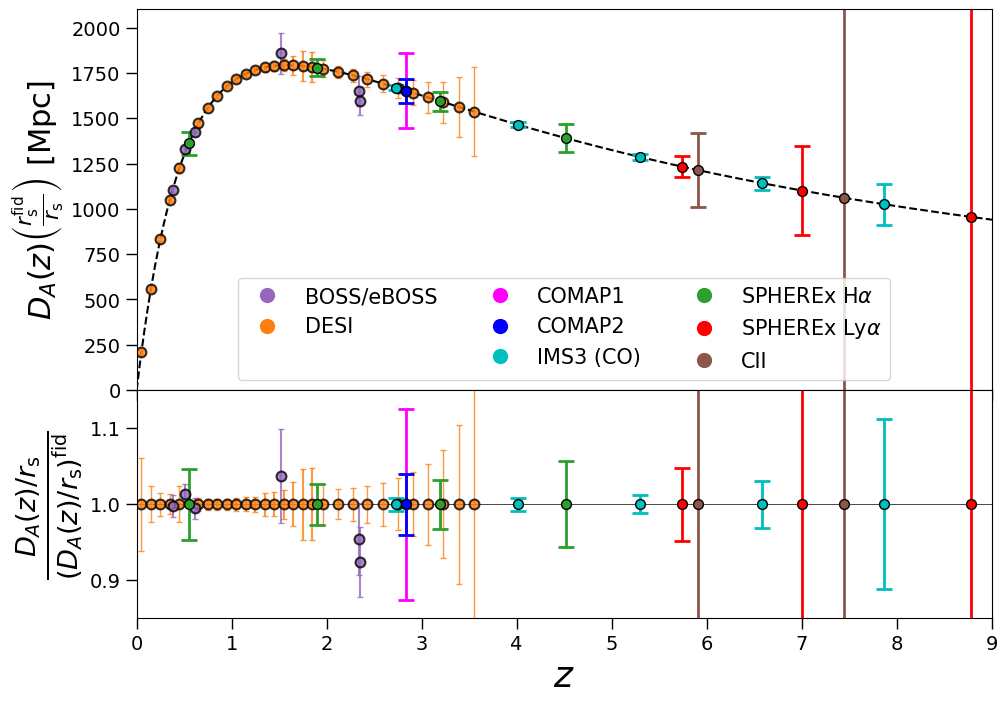

In [42]:
###### DA(z) plot

color = plt.rcParams['axes.prop_cycle'].by_key()['color']
f, ax = plt.subplots(2,1, gridspec_kw = {'hspace':0,'height_ratios':[5,3],'top':.98,'right':.98}, sharex='col',figsize=(10,7))

#DA(z)
ax[0].plot(zint,DAint(zint)*(zint)**0,lw=1.5,c='k',zorder=0,ls='--')

ax[0].errorbar(z_eboss,DA_eboss*(z_eboss)**0,yerr=sigma_DA_eboss*(z_eboss)**0,capsize=2,capthick=1,color=color[4],zorder=1,ls='',alpha=0.8)
ax[0].scatter(z_eboss,DA_eboss*(z_eboss)**0,color=color[4],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,label='BOSS/eBOSS',alpha=0.8)
ax[0].errorbar(z_desi,DAint(z_desi)*(z_desi)**0,yerr=sigma_DA_desi*DAint(z_desi)*(z_desi)**0,capsize=2,capthick=1,color=color[1],zorder=1,ls='',alpha=0.8)
ax[0].errorbar(z_desi_Lya,DAint(z_desi_Lya)*(z_desi_Lya)**0,yerr=sigma_DA_desi_Lya*DAint(z_desi_Lya)*(z_desi_Lya)**0,capsize=2,capthick=1,color=color[1],lw=1,zorder=1,ls='',alpha=0.8)
ax[0].errorbar(z_desi_bgs,DAint(z_desi_bgs)*(z_desi_bgs)**0,yerr=sigma_DA_desi_bgs*DAint(z_desi_bgs)*(z_desi_bgs)**0,capsize=2,capthick=1,color=color[1],lw=1,zorder=1,ls='',alpha=0.8)
ax[0].scatter(z_desi,DAint(z_desi)*(z_desi)**0,color=color[1],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,alpha=0.8)
ax[0].scatter(z_desi_bgs,DAint(z_desi_bgs)*(z_desi_bgs)**0,color=color[1],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,alpha=0.8)
ax[0].scatter(z_desi_Lya,DAint(z_desi_Lya)*(z_desi_Lya)**0,color=color[1],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,label='DESI',alpha=0.8)
ax[0].errorbar(z_bossdr12,DA_bossdr12*(z_bossdr12)**0,yerr=sigma_DA_bossdr12*(z_bossdr12)**0,capsize=2,capthick=1,color=color[4],zorder=1,ls='',alpha=0.8)
ax[0].scatter(z_bossdr12,DA_bossdr12*(z_bossdr12)**0,color=color[4],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,alpha=0.8)
ax[0].errorbar(z_bossdr14_Lya,DA_bossdr14_Lya*(z_bossdr14_Lya)**0,yerr=sigma_DA_bossdr14_Lya*(z_bossdr14_Lya)**0,capsize=2,capthick=1,color=color[4],zorder=1,ls='',alpha=0.8)
ax[0].scatter(z_bossdr14_Lya,DA_bossdr14_Lya*(z_bossdr14_Lya)**0,color=color[4],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,alpha=0.8)
ax[0].errorbar(zsx_halpha,DAint(zsx_halpha)*(zsx_halpha)**0,elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_perp_sxdeep_halpha*DAint(zsx_halpha)*(zsx_halpha)**0,color=color[2],zorder=1,ls='')
ax[0].scatter(zsx_halpha,DAint(zsx_halpha)*(zsx_halpha)**0,color=color[2],marker='o',s=50,edgecolors='k',lw=1,zorder=2,label=r'SPHEREx (H$\alpha$)')
ax[0].errorbar(zsx_lyalpha,DAint(zsx_lyalpha)*(zsx_lyalpha)**0,elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_perp_sxdeep_lyalpha*DAint(zsx_lyalpha)*(zsx_lyalpha)**0,color='r',zorder=1,ls='')
ax[0].scatter(zsx_lyalpha,DAint(zsx_lyalpha)*(zsx_lyalpha)**0,color='r',marker='o',s=50,edgecolors='k',lw=1,zorder=2,label=r'SPHEREx (Ly$\alpha$)')
ax[0].errorbar(z_comap1,DAint(z_comap1)*(z_comap1)**0,elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_perp_comap1*DAint(z_comap1)*(z_comap1)**0,color='fuchsia',zorder=1,ls='')
ax[0].scatter(z_comap1,DAint(z_comap1)*(z_comap1)**0,color='fuchsia',marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='COMAP1')
ax[0].errorbar(z_comap,DAint(z_comap)*(z_comap)**0,elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_perp_comap*DAint(z_comap)*(z_comap)**0,color='b',zorder=1,ls='')
ax[0].scatter(z_comap,DAint(z_comap)*(z_comap)**0,color='b',marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='COMAP2')
ax[0].errorbar(z_ims3,DAint(z_ims3)*(z_ims3)**0,elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_perp_ims3*DAint(z_ims3)*(z_ims3)**0,color='c',zorder=1,ls='')
ax[0].scatter(z_ims3,DAint(z_ims3)*(z_ims3)**0,color='c',marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='IMS3 (CO)')

ax[0].errorbar(zcii_stageii,DAint(zcii_stageii)*(zcii_stageii)**0,elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_perp_cii_stageii*DAint(zcii_stageii)*(zcii_stageii)**0,color=color[5],zorder=1,ls='')
ax[0].scatter(zcii_stageii,DAint(zcii_stageii)*(zcii_stageii)**0,color=color[5],marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='COMAP2')


# ax[0].errorbar(zcii_CCAT,DAint(zcii_CCAT)*(zcii_CCAT)**0,elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_perp_CCAT_cii*DAint(zcii_CCAT)*(zcii_CCAT)**0,color='y',zorder=1,ls='')
# ax[0].scatter(zcii_CCAT,DAint(zcii_CCAT)*(zcii_CCAT)**0,color='y',marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='COMAP2')
ax[0].set_xlim(0.0,9)
ax[0].set_ylim(0,2100)
ax[0].set_xlabel(r'$z$',fontsize=22)
ax[0].set_ylabel(r'$D_A(z)\left(\frac{r_{\rm s}^{\rm fid}}{r_{\rm s}}\right)$ [Mpc]',fontsize=22)
ax[0].tick_params(axis='both',width=1,length=8,labelsize=14)
#legend = ax[0].legend(loc=4,fontsize=14,ncol=3,markerscale=1.8)

#######

ax[1].plot(zint,DAint(zint)/DAint(zint),lw=.5,c='k',zorder=0,ls='-')

ax[1].errorbar(z_desi,DAint(z_desi)/DAint(z_desi),yerr=sigma_DA_desi*DAint(z_desi)/DAint(z_desi),capsize=2,capthick=1,color=color[1],zorder=1,ls='',alpha=0.8)
ax[1].errorbar(z_desi_Lya,DAint(z_desi_Lya)/DAint(z_desi_Lya),yerr=sigma_DA_desi_Lya*DAint(z_desi_Lya)/DAint(z_desi_Lya),capsize=2,capthick=1,color=color[1],lw=1,zorder=1,ls='',alpha=0.8)
ax[1].errorbar(z_desi_bgs,DAint(z_desi_bgs)/DAint(z_desi_bgs),yerr=sigma_DA_desi_bgs*DAint(z_desi_bgs)/DAint(z_desi_bgs),capsize=2,capthick=1,color=color[1],lw=1,zorder=1,ls='',alpha=0.8)
ax[1].scatter(z_desi,DAint(z_desi)/DAint(z_desi),color=color[1],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,alpha=0.8)
ax[1].scatter(z_desi_bgs,DAint(z_desi_bgs)/DAint(z_desi_bgs),color=color[1],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,alpha=0.8)
ax[1].scatter(z_desi_Lya,DAint(z_desi_Lya)/DAint(z_desi_Lya),color=color[1],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,label='DESI',alpha=0.8)
ax[1].errorbar(z_bossdr12,DA_bossdr12/DAint(z_bossdr12),yerr=sigma_DA_bossdr12/DAint(z_bossdr12),capsize=2,capthick=1,color=color[4],zorder=1,ls='',alpha=0.8)
ax[1].scatter(z_bossdr12,DA_bossdr12/DAint(z_bossdr12),color=color[4],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,label='BOSS',alpha=0.8)
ax[1].errorbar(z_bossdr14_Lya,DA_bossdr14_Lya/DAint(z_bossdr14_Lya),yerr=sigma_DA_bossdr14_Lya/DAint(z_bossdr14_Lya),capsize=2,capthick=1,color=color[4],zorder=1,ls='',alpha=0.8)
ax[1].scatter(z_bossdr14_Lya,DA_bossdr14_Lya/DAint(z_bossdr14_Lya),color=color[4],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,alpha=0.8)
ax[1].errorbar(z_eboss,DA_eboss/DAint(z_eboss),yerr=sigma_DA_eboss/DAint(z_eboss),capsize=2,capthick=1,color=color[4],zorder=1,ls='',alpha=0.8)
ax[1].scatter(z_eboss,DA_eboss/DAint(z_eboss),color=color[4],marker='o',s=50,edgecolors='k',linewidth=1.5,zorder=2,label='eBOSS',alpha=0.8)
ax[1].errorbar(z_comap1,DAint(z_comap1)/DAint(z_comap1),elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_perp_comap1*DAint(z_comap1)/DAint(z_comap1),color='fuchsia',zorder=1,ls='')
ax[1].scatter(z_comap1,DAint(z_comap1)/DAint(z_comap1),color='fuchsia',marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='COMAP1')
ax[1].errorbar(z_comap,DAint(z_comap)/DAint(z_comap),elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_perp_comap*DAint(z_comap)/DAint(z_comap),color='b',zorder=1,ls='')
ax[1].scatter(z_comap,DAint(z_comap)/DAint(z_comap),color='b',marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='COMAP2')
ax[1].errorbar(z_ims3,DAint(z_ims3)/DAint(z_ims3),elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_perp_ims3*DAint(z_ims3)/DAint(z_ims3),color='c',zorder=1,ls='')

ax[1].errorbar(zcii_stageii,DAint(zcii_stageii)/DAint(zcii_stageii),elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_perp_cii_stageii,color=color[5],zorder=1,ls='')
ax[1].scatter(zcii_stageii,DAint(zcii_stageii)/DAint(zcii_stageii),color=color[5],marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='CO IMS3')

ax[1].scatter(z_ims3,DAint(z_ims3)/DAint(z_ims3),color='c',marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='CO IMS3')
ax[1].errorbar(zsx_halpha,DAint(zsx_halpha)/DAint(zsx_halpha),elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_perp_sxdeep_halpha*DAint(zsx_halpha)/DAint(zsx_halpha),color=color[2],zorder=1,ls='')
ax[1].scatter(zsx_halpha,DAint(zsx_halpha)/DAint(zsx_halpha),color=color[2],marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='CO IMS3')
ax[1].errorbar(zsx_lyalpha,DAint(zsx_lyalpha)/DAint(zsx_lyalpha),elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_perp_sxdeep_lyalpha,color='r',zorder=1,ls='')
ax[1].scatter(zsx_lyalpha,DAint(zsx_lyalpha)/DAint(zsx_lyalpha),color='r',marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='CO IMS3')
# ax[1].errorbar(zcii_CCAT,DAint(zcii_CCAT)/DAint(zcii_CCAT),elinewidth=2,capsize=6,capthick=2,yerr=sigma_alpha_perp_CCAT_cii,color='y',zorder=1,ls='')
# ax[1].scatter(zcii_CCAT,DAint(zcii_CCAT)/DAint(zcii_CCAT),color='y',marker='o',s=50,edgecolors='k',lw=1,zorder=2,label='CO IMS3')
ax[1].set_xlim(0.0,9)
ax[1].set_xlabel(r'$z$',fontsize=26)
ax[1].set_ylabel(r'$\frac{D_A(z)/r_{\rm s}}{\left( D_A(z)/r_{\rm s} \right)^{\rm fid}}$',fontsize=28)
ax[1].tick_params(axis='both',width=1,length=8,labelsize=14)
ax[1].set_ylim(0.85,1.15)

legend = [Line2D([-1], [-1], marker='o', color='w', label='BOSS/eBOSS',
                        markerfacecolor=color[4], markersize=12),
          Line2D([-1], [-1], marker='o', color='w', label='DESI',
                        markerfacecolor=color[1], markersize=12),
          Line2D([-1], [-1], marker='o', color='w', label='',
                        markerfacecolor='w', markersize=12),
          Line2D([-1], [-1], marker='o', color='w', label='COMAP1',
                        markerfacecolor='fuchsia', markersize=12),
         Line2D([-1], [-1], marker='o', color='w', label='COMAP2',
                        markerfacecolor='b', markersize=12),
         Line2D([-1], [-1], marker='o', color='w', label='IMS3 (CO)',
                        markerfacecolor='c', markersize=12),
         Line2D([-1], [-1], marker='o', color='w', label=r'SPHEREx H$\alpha$',
                        markerfacecolor=color[2], markersize=12),
         Line2D([-1], [-1], marker='o', color='w', label=r'SPHEREx Ly$\alpha$',
                        markerfacecolor='r', markersize=12),
         Line2D([-1], [-1], marker='o', color='w', label='CII',
                        markerfacecolor=color[5], markersize=12),
#           Line2D([-1], [-1], marker='o', color='w', label='CCAT',
#                         markerfacecolor='y', markersize=12),
         ]
ax[0].legend(handles=legend,loc=8,frameon=True, fontsize=15,ncol=3)


# plt.savefig('/Users/jlbernal/Dropbox/JoseLuis/PhD/RESEARCH/IM/Shared_Draft_CO/Figures/DA_constraints.pdf')

In [28]:
print(sigma_alpha_perp_CCAT_cii)
print(sigma_alpha_perp_sxdeep_lyalpha)

[ 0.69363154  0.31593553  0.71461665 10.64157052]
[0.04819086 0.22213987 1.62575775]


correlation = 0.13961245481174375

correlation = -0.4161045961964072
correlation = -0.4011278348841468
correlation = -0.5017206173319491
correlation = -0.5764705238780634


Text(0.87, 30.5, '$z=7.63$')

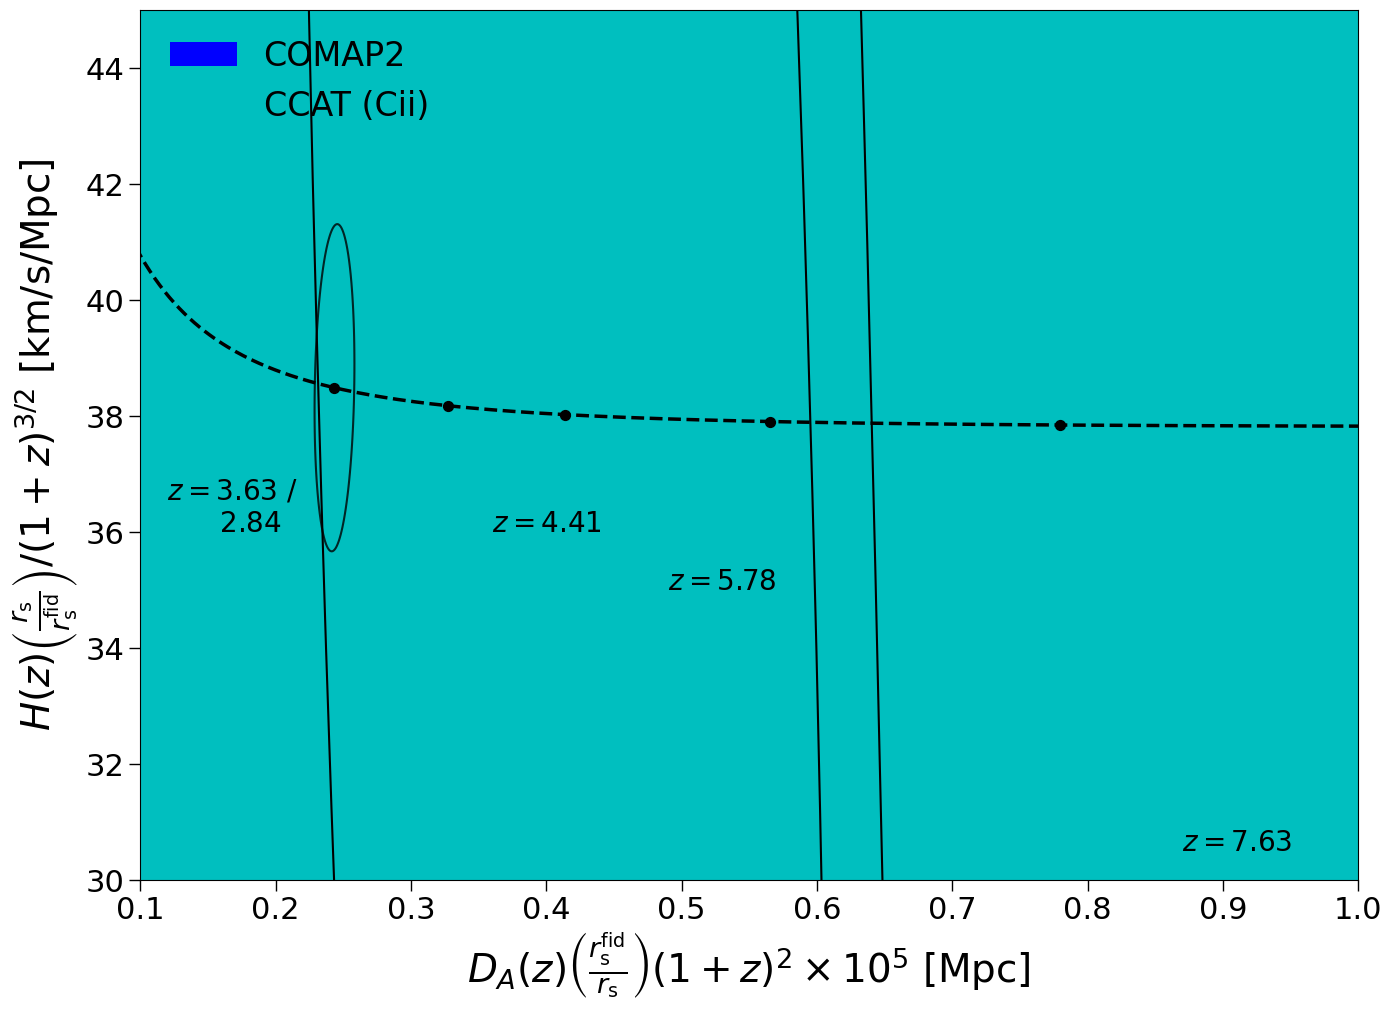

In [29]:

gs = gridspec.GridSpec(1, 1,top=.98,right=.97,left=0.1)
fig = plt.figure(figsize=(14,10))
ax = plt.subplot(gs[0])

###

var = np.arange(2,8)

ax.plot(DAint(zint)*(1+zint)**2/1e5,Hint(zint)*(1+zint)**-1.5,lw=2.5,c='k',zorder=10,ls='--')

#for iz in range(1):
#    vartemp = var
    
#    covmat = inv(fisher_spherexdeep_Lymanalpha[iz][np.ix_(vartemp,vartemp)])
#    plot_2d(covmat,[0,1],[1,1],ax,color='r',filled=True,TwoSigma=False,
#            factors=[DAint(zsx_lyalpha[iz])*(1+zsx_lyalpha[iz])**2/1e5,Hint(zsx_lyalpha[iz])*(1.+zsx_lyalpha[iz])**-1.5],alpha=0.8)

#print ''

#for iz in range(1):
#    vartemp = var
    
#    covmat = inv(fisher_comap1[iz][np.ix_(vartemp,vartemp)])
#    plot_2d(covmat,[0,1],[1,1],ax,color='fuchsia',filled=True,TwoSigma=False,
#            factors=[DAint(z_comap1[iz])*(1+z_comap1[iz])**2/1e5,Hint(z_comap1[iz])*(1.+z_comap1[iz])**-1.5],alpha=0.8)
#print ''

#for iz in range(4):
#    vartemp = var
    
#    covmat = inv(fisher_spherexdeep_Halpha[iz][np.ix_(vartemp,vartemp)])
#    plot_2d(covmat,[0,1],[1,1],ax,color=color[2],filled=True,TwoSigma=False,
#            factors=[DAint(zsx_halpha[iz])*(1+zsx_halpha[iz])**2/1e5,Hint(zsx_halpha[iz])*(1.+zsx_halpha[iz])**-1.5],alpha=0.8)
#print ''    
  

for iz in range(1):
    vartemp = var
    
    covmat = inv(fisher_comap2[iz][np.ix_(vartemp,vartemp)])
    plot_2d(covmat,[0,1],[1,1],ax,color='b',filled=True,TwoSigma=False,
            factors=[DAint(z_comap[iz])*(1+z_comap[iz])**2/1e5,Hint(z_comap[iz])*(1.+z_comap[iz])**-1.5],alpha=0.8)
print( '')

for iz in range(4):
    vartemp = var
    
    covmat = inv(fisher_CCAT_cii[iz][np.ix_(vartemp,vartemp)])
    plot_2d(covmat,[0,1],[1,1],ax,color='c',filled=True,TwoSigma=False,
            factors=[DAint(zcii_CCAT[iz])*(1+zcii_CCAT[iz])**2/1e5,Hint(zcii_CCAT[iz])*(1.+zcii_CCAT[iz])**-1.5])



#ax.text(0.22,65,r'$z=2.73$',fontsize=15)    
#ax.text(0.36,75,r'$z=4.01$',fontsize=15)    
#ax.text(0.49,82,r'$z=5.30$',fontsize=15)    
#ax.text(0.86,82,r'$z=6.58$',fontsize=15)    
#ax.text(0.9,65,r'$z=7.87$',fontsize=15)    
ax.set_ylim(30,45)
ax.set_xlim(0.1,1)
ax.set_xlabel(r'$D_A(z)\left(\frac{r_{\rm s}^{\rm fid}}{r_{\rm s}}\right)(1+z)^2\times 10^5$ [Mpc]',fontsize=28)
ax.set_ylabel(r'$H(z)\left(\frac{r_{\rm s}}{r_{\rm s}^{\rm fid}}\right)/(1+z)^{3/2}$ [km/s/Mpc]',fontsize=28)
ax.tick_params(axis='both',width=1,length=8,labelsize=22)
ax.ticklabel_format(axis='x',style='sci')
#proxy = [plt.Rectangle((0,0),1,1,fc = color[2]),plt.Rectangle((0,0),1,1,fc = color[3]),
#        plt.Rectangle((0,0),1,1,fc = 'white'),plt.Rectangle((0,0),1,1,fc = 'fuchsia'),
#        plt.Rectangle((0,0),1,1,fc = 'b'),plt.Rectangle((0,0),1,1,fc = 'c')]
#ax.legend(proxy, [r'SPHEREx (H$\alpha$)',r'SPHEREx (Ly$\alpha$)',r'',r'COMAP 1',r'COMAP2',r'IMS3 (CO)'],
#          loc=1,frameon=False, fontsize=20,ncol=2)

proxy = [plt.Rectangle((0,0),1,1,fc = 'b'),plt.Rectangle((0,0),1,1,fc = 'c')]
ax.legend(proxy,[r'COMAP2',r'CCAT (Cii)'],loc=2,frameon=False, fontsize=24,ncol=1)

ax.text(0.12,36,'$z=3.63$ /\n      $2.84$',fontsize=20)    
ax.text(0.36,36,r'$z=4.41$',fontsize=20)    
ax.text(0.49,35,r'$z=5.78$',fontsize=20)    
# ax.text(0.64,33,r'$z=6.58$',fontsize=20)    
ax.text(0.87,30.5,r'$z=7.63$',fontsize=20)    

# plt.savefig('/Users/jlbernal/Dropbox/JoseLuis/PhD/RESEARCH/IM/Shared_Draft_CO/Figures/DA_H_constraints.pdf')

In [30]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
all_spherex_deep = fisher_spherexdeep_Halpha+fisher_spherexdeep_Lymanalpha

z = [0.54869906, 1.90047772, 3.19776124, 4.5163192,5.73893394, 7.00696856, 8.77781511]
M = lim()
Da_over_rs = []
H_times_rs = []
IM_covmats = []

vartemp = range(2,8)
for iz in range(len(z)):
    M.update(nuObs=M.nu/(z[iz]+1))
    Da_over_rs_fid = M.Alcock_Packynski_params[0]
    H_times_rs_fid = M.Alcock_Packynski_params[1]
    mean = np.array([Da_over_rs_fid,H_times_rs_fid])
    covmat = inv(all_spherex_deep[iz][np.ix_(vartemp,vartemp)])[:2,:2]
    covmat = np.dot(np.diag(mean),np.dot(covmat,np.diag(mean)))
    while True:
        DA,H = np.random.multivariate_normal(mean, covmat, 1).T
        if DA>0 and H>0:
            print( DA, H)
            break
    Da_over_rs.append(DA)
    H_times_rs.append(H)
    IM_covmats.append(covmat)
        
for iz in range(len(zcii_CCAT)):
    z.append(zcii_CCAT[iz])
    M.update(nuObs=M.nu/(zcii_CCAT[iz]+1))
    Da_over_rs_fid = M.Alcock_Packynski_params[0]
    H_times_rs_fid = M.Alcock_Packynski_params[1]
    mean = np.array([Da_over_rs_fid,H_times_rs_fid])
    covmat = inv(fisher_CCAT_cii[iz][np.ix_(vartemp,vartemp)])[:2,:2]
    covmat = np.dot(np.diag(mean),np.dot(covmat,np.diag(mean)))
    DA,H = np.random.multivariate_normal(mean, covmat, 1).T
    Da_over_rs.append(DA)
    H_times_rs.append(H)
    IM_covmats.append(covmat)

for iz in range(len(z_ims3)):
    z.append(z_ims3[iz])
    M.update(nuObs=M.nu/(z_ims3[iz]+1))
    Da_over_rs_fid = M.Alcock_Packynski_params[0]
    H_times_rs_fid = M.Alcock_Packynski_params[1]
    mean = np.array([Da_over_rs_fid,H_times_rs_fid])
    covmat = inv(fisher_ims3[iz][np.ix_(vartemp,vartemp)])[:2,:2]
    covmat = np.dot(np.diag(mean),np.dot(covmat,np.diag(mean)))
    DA,H = np.random.multivariate_normal(mean, covmat, 1).T
    Da_over_rs.append(DA)
    H_times_rs.append(H)
    IM_covmats.append(covmat)
 
    
fil = open('covmats/mock_results_DA_H_spherex_CII_IMS3.txt','w')
fil.write('#BAO mock im results. SPHEREx Halpha - SPHEREx Lyalpha - CII StageII - IMS3 CO\n')
for i in range(len(z)):
    fil.write('{:f}\t'.format(z[i]))
    fil.write('{:d}\t'.format(0))
    fil.write('{:f}\n'.format(Da_over_rs[i][0]))
    
    fil.write('{:f}\t'.format(z[i]))
    fil.write('{:d}\t'.format(1))
    fil.write('{:f}\n'.format(H_times_rs[i][0]))
    
    
fil.close() 

save_obj(IM_covmats,'covmats/mock_covmats_DA_spherex_CII_IMS3')

### Correlation matrices

In [ ]:
#Save marginalized covmat with cosmo and alpha_par, alpha_perp and Tfs8
lcdm_hexadec = []
lcdm = []

NZ = 5
Nfield_factor = 1.
for iz in range(NZ):
    lcdm_hexadec.append(inv(Nfield_factor*fisher_ims3[iz][2:,2:])[:3,:3])
    lcdm.append(inv(Nfield_factor*fisher_ims3_nohexadec[iz][2:,2:])[:3,:3])

    


In [ ]:
corrmat = []

for iz in range(5):
    temp = correlation_matrix(lcdm[iz])
    temp_hexadec = correlation_matrix(lcdm_hexadec[iz])
    for i in range(temp.shape[0]):
        temp[i,i] = None
        for j in range(i+1,temp.shape[0]):
            temp[i,j] = temp_hexadec[i,j]
    corrmat.append(temp)
            

zvec = [2.73,4.01,5.3,6.58,7.87]  

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

#f, ax = plt.subplot(nrows=2,ncols=3, sharex=True, figsize=(12,8))
gs_top = gridspec.GridSpec(2, 3,bottom=0.2,wspace=0.3)
gs_bot = gridspec.GridSpec(2, 4,bottom=0.2,wspace=0.4,width_ratios=[1,3,3,1])
#gs_bot = gridspec.GridSpec(4,2)
f = plt.figure(figsize=(12,10))

ax = plt.subplot(gs_top[0,0])
cax = ax.matshow(corrmat[0],cmap='seismic',vmin = -1,vmax=1)
write_vals(corrmat[0],ax)
ax.set_title('$z = $'+str(zvec[0]),fontsize=20,pad=25)
ax.tick_params(axis='both',width=0,length=0,labelsize=22)
ax.set_yticklabels([r'$\alpha_\perp$',r'$\alpha_\parallel$',r'$\langle T\rangle f\sigma_8$'],rotation='vertical',va='center')
ax.set_xticklabels([r'$\alpha_\perp$',r'$\alpha_\parallel$',r'$\langle T\rangle f\sigma_8$'])
ax.set_xticks([0,1,2])
ax.set_yticks([0,1,2])
ax.text(0.5,2.9,r'$\ell=\lbrace 0,2\rbrace$',fontsize=22,horizontalalignment='center')


ax = plt.subplot(gs_top[0,1])
ax.matshow(corrmat[1],cmap='seismic',vmin = -1,vmax=1)
write_vals(corrmat[1],ax)
ax.set_title('$z = $'+str(zvec[1]),fontsize=20,pad=25)
ax.tick_params(axis='both',width=0,length=0,labelsize=22)
ax.set_yticklabels([r'$\alpha_\perp$',r'$\alpha_\parallel$',r'$\langle T\rangle f\sigma_8$'],rotation='vertical',va='center')
ax.set_xticklabels([r'$\alpha_\perp$',r'$\alpha_\parallel$',r'$\langle T\rangle f\sigma_8$'])
ax.set_xticks([0,1,2])
ax.set_yticks([0,1,2])

ax = plt.subplot(gs_top[0,2])
ax.matshow(corrmat[2],cmap='seismic',vmin = -1,vmax=1)
write_vals(corrmat[2],ax)
ax.set_title('$z = $'+str(zvec[2]),fontsize=20,pad=25)
ax.tick_params(axis='both',width=0,length=0,labelsize=22)
ax.set_yticklabels([r'$\alpha_\perp$',r'$\alpha_\parallel$',r'$\langle T\rangle f\sigma_8$'],rotation='vertical',va='center')
ax.set_xticklabels([r'$\alpha_\perp$',r'$\alpha_\parallel$',r'$\langle T\rangle f\sigma_8$'])
ax.set_xticks([0,1,2])
ax.set_yticks([0,1,2])
ax.text(2.7,-.1,r'$\ell=\lbrace 0,2,4\rbrace$',fontsize=22,rotation='vertical')


ax = plt.subplot(gs_bot[1,1])
ax.matshow(corrmat[3],cmap='seismic',vmin = -1,vmax=1)
write_vals(corrmat[3],ax)
ax.set_title('$z = $'+str(zvec[3]),fontsize=20,pad=25)
ax.tick_params(axis='both',width=0,length=0,labelsize=22)
ax.set_yticklabels([r'$\alpha_\perp$',r'$\alpha_\parallel$',r'$\langle T\rangle f\sigma_8$'],rotation='vertical',va='center')
ax.set_xticklabels([r'$\alpha_\perp$',r'$\alpha_\parallel$',r'$\langle T\rangle f\sigma_8$'])
ax.set_xticks([0,1,2])
ax.set_yticks([0,1,2])


ax = plt.subplot(gs_bot[1,2])
ax.matshow(corrmat[4],cmap='seismic',vmin = -1,vmax=1)
write_vals(corrmat[4],ax)
ax.set_title('$z = $'+str(zvec[4]),fontsize=20,pad=25)
ax.tick_params(axis='both',width=0,length=0,labelsize=22)
ax.set_yticklabels([r'$\alpha_\perp$',r'$\alpha_\parallel$',r'$\langle T\rangle f\sigma_8$'],rotation='vertical',va='center')
ax.set_xticklabels([r'$\alpha_\perp$',r'$\alpha_\parallel$',r'$\langle T\rangle f\sigma_8$'])
ax.set_xticks([0,1,2])
ax.set_yticks([0,1,2])

cbar_ax = f.add_axes([0.1, 0.08, 0.8, 0.05])
cbar = f.colorbar(cax,orientation='horizontal', cax=cbar_ax)

cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_xlabel(r'Correlation', fontsize=24,labelpad = 10)
cbar.ax.tick_params(labelsize=20,size = 5.) 

plt.subplots_adjust(top=0.94)
plt.subplots_adjust(left=0.04)
plt.subplots_adjust(bottom=0.0)
plt.subplots_adjust(right=0.95)
# plt.savefig('/Users/jlbernal/Dropbox/JoseLuis/PhD/RESEARCH/IM/Shared_Draft_CO/Figures/correlations.pdf')

In [ ]:
#Get the Tfs8 values
obs,NUOBS,DELTANU,dnu,freq,Tsys = survey_pars(survey='IMS3')
Tfs8 = []
fidmod = prepare_model(5,kkind='linear',model='TonyLi')
for iz in range(len(NUOBS)):
    INPUT = merge_dicts([fidmod,obs,dict(nuObs=NUOBS[iz],Delta_nu=DELTANU[iz],Tsys_NEFD=Tsys[iz],dnu=dnu[iz]),freq])
    M = lim(INPUT)
    Tfs8.append(fiducial(M)[4].value)

In [ ]:
#Make the corner plot
color = plt.rcParams['axes.prop_cycle'].by_key()['color']

gs = gridspec.GridSpec(3, 3,top=.98,right=.97,left=0.12,bottom=0.14,hspace=0,wspace=0)
fig = plt.figure(figsize=(10,8))

alpha_lin = np.linspace(0.92,1.08,100)
Tfs8_lin = np.linspace(0.5,1.,100)

#alpha perp, alpha par, Tfs8
## 0,0
ax = plt.subplot(gs[0,0])
ax.plot(alpha_lin,gaussian(alpha_lin,1,lcdm[0][0,0]**0.5),color=color[0],lw=3)
ax.plot(alpha_lin,gaussian(alpha_lin,1,lcdm_hexadec[0][0,0]**0.5),color=color[1],lw=3)
ax.tick_params(axis='both',width=1,length=8,labelsize=18)
ax.tick_params(axis='both',width=0,length=0,labelsize=0)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlim(0.92,1.08)

## 1,1
ax = plt.subplot(gs[1,1])
ax.plot(alpha_lin,gaussian(alpha_lin,1,lcdm[0][1,1]**0.5),color=color[0],lw=3)
ax.plot(alpha_lin,gaussian(alpha_lin,1,lcdm_hexadec[0][1,1]**0.5),color=color[1],lw=3)
ax.tick_params(axis='both',width=0,length=0,labelsize=0)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xlim(0.92,1.08)


## 2,2
ax = plt.subplot(gs[2,2])
ax.plot(Tfs8_lin,gaussian(Tfs8_lin,Tfs8[0],lcdm[0][2,2]**0.5),color=color[0],lw=3)
ax.plot(Tfs8_lin,gaussian(Tfs8_lin,Tfs8[0],lcdm_hexadec[0][2,2]**0.5),color=color[1],lw=3)
ax.set_xlabel(r'$\langle T \rangle f\sigma_8$',fontsize=26)
ax.tick_params(axis='x',width=1,length=8,labelsize=18)
ax.tick_params(axis='y',width=0,length=0,labelsize=0)
ax.set_yticklabels([])
ax.set_xlim(0.65,.93)


## 1,0
ax = plt.subplot(gs[1,0])
plot_2d(lcdm[0],[0,1],[1,1],ax,color=color[0],filled=True,TwoSigma=False,alpha=1)
plot_2d(lcdm_hexadec[0],[0,1],[1,1],ax,color=color[1],filled=True,TwoSigma=False,alpha=1)
ax.set_ylabel(r'$\alpha_{\parallel}$',fontsize=26)
ax.tick_params(axis='y',width=1,length=8,labelsize=18)
ax.tick_params(axis='x',width=0,length=0,labelsize=0)
ax.set_xticklabels([])
ax.set_xlim(0.92,1.08)
ax.set_ylim(0.92,1.08)

## 2,0
ax = plt.subplot(gs[2,0])
plot_2d(lcdm[0],[0,2],[1,Tfs8[0]],ax,color=color[0],filled=True,TwoSigma=False,alpha=1)
plot_2d(lcdm_hexadec[0],[0,2],[1,Tfs8[0]],ax,color=color[1],filled=True,TwoSigma=False,alpha=1)
ax.set_ylabel(r'$\langle T\rangle f\sigma_8$',fontsize=26)
ax.set_xlabel(r'$\alpha_\perp$',fontsize=26)
ax.tick_params(axis='both',width=1,length=8,labelsize=18)
ax.set_ylim(0.65,.93)
ax.set_xlim(0.92,1.08)


## 2,1
ax = plt.subplot(gs[2,1])
plot_2d(lcdm[0],[1,2],[1,Tfs8[0]],ax,color=color[0],filled=True,TwoSigma=False,alpha=1)
plot_2d(lcdm_hexadec[0],[1,2],[1,Tfs8[0]],ax,color=color[1],filled=True,TwoSigma=False,alpha=1)
ax.set_xlabel(r'$\alpha_{\parallel}$',fontsize=26)
ax.tick_params(axis='x',width=1,length=8,labelsize=18)
ax.tick_params(axis='y',width=0,length=0,labelsize=0)
ax.set_yticklabels([])
ax.set_ylim(0.65,.93)
ax.set_xlim(0.92,1.08)

# 3,3 legend

ax = plt.subplot(gs[0,2])
just = mpatches.Patch(color=color[0], label=r'$\ell = \lbrace 0,2\rbrace$',alpha=1)
al = mpatches.Patch(color=color[1], label=r'$\ell = \lbrace 0,2,4\rbrace$',alpha=1)
lines = [just,al]
ax.axis('off')
ax.legend(lines,(r'$\ell = \lbrace 0,2\rbrace$',r'$\ell = \lbrace 0,2,4\rbrace$'),loc='center',handlelength=0.9, handleheight=0.15, handletextpad = 0.5, fontsize = 24 )

# plt.savefig('/Users/jlbernal/Dropbox/JoseLuis/PhD/RESEARCH/IM/Shared_Draft_CO/Figures/corner.pdf')

### S/N(k)

In [ ]:
SURVEY = 'IMS3'
fidmod = prepare_model(5,kkind='linear',model='TonyLi')
#Load survey specs
obs,NUOBS,DELTANU,dnu,freq,Tsys = survey_pars(survey='IMS3')
NZ = len(NUOBS)
print(  SURVEY + ' survey has {0:2d} redshift bin(s)'.format(NZ))

SNR = []
SNR2 = []
SNR3 = []
k = []
z = []
for iz in range(NZ):
    INPUT = merge_dicts([fidmod,obs,dict(smooth=True,nuObs=NUOBS[iz],Delta_nu=DELTANU[iz],Tsys_NEFD=Tsys[iz],dnu=dnu[iz]),freq])
    #Call lim
    M = lim(INPUT)
    M.update(kmin = M.kmin_field)
    M.update(kmax = min(1*M.Mpch**-1,M.kmax_field.to(M.Mpch**-1)))
    
    Pkvec2 = np.zeros(2)
    Pkvec3 = np.zeros(3)
    minicov2 = np.zeros((2,2))
    minicov3 = np.zeros((3,3))
    snr = np.zeros(M.nk)
    snr2 = np.zeros(M.nk)
    snr3 = np.zeros(M.nk)
    
    Pk0 = M.Pk_0.to(M.Mpch**3*u.uK**2)
    Pk2 = M.Pk_2.to(M.Mpch**3*u.uK**2)
    Pk4 = M.Pk_4.to(M.Mpch**3*u.uK**2)
    
    cov00 = M.covmat_00.to(M.Mpch**6*u.uK**4)
    cov02 = M.covmat_02.to(M.Mpch**6*u.uK**4)
    cov04 = M.covmat_04.to(M.Mpch**6*u.uK**4)
    cov22 = M.covmat_22.to(M.Mpch**6*u.uK**4)
    cov24 = M.covmat_24.to(M.Mpch**6*u.uK**4)
    cov44 = M.covmat_44.to(M.Mpch**6*u.uK**4)
    
    k.append(M.k.to(M.Mpch**-1))
    z.append(M.z)
    
    for ik in range(M.nk):
        minicov2[0,0] = cov00[ik].value
        minicov2[1,0] = cov02[ik].value
        minicov2[0,1] = cov02[ik].value
        minicov2[1,1] = cov22[ik].value
        
        minicov3[:2,:2] = minicov2
        minicov3[0,2] = cov04[ik].value
        minicov3[2,0] = cov04[ik].value
        minicov3[1,2] = cov24[ik].value
        minicov3[2,1] = cov24[ik].value
        minicov3[2,2] = cov44[ik].value
        
        Pkvec2[0] = Pk0[ik].value
        Pkvec2[1] = Pk2[ik].value
        Pkvec3[:2] = Pkvec2
        Pkvec3[2] = Pk4[ik].value
        
        snr[ik] = (Pk0[ik]**2).value/cov00[ik].value
        snr2[ik] = np.dot(Pkvec2,np.dot(inv(minicov2),Pkvec2))
        snr3[ik] = np.dot(Pkvec3,np.dot(inv(minicov3),Pkvec3))
        
    SNR.append(snr)
    SNR2.append(snr2)
    SNR3.append(snr3)
        
    

In [ ]:
prop_cycle = plt.rcParams['axes.prop_cycle']
color = prop_cycle.by_key()['color']

gs = gridspec.GridSpec(1, 1)
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(gs[0])

for iz in range(5):
    ax.loglog(k[iz],SNR[iz]**0.5,lw=2,ls=':',color=color[iz])
    ax.loglog(k[iz],SNR2[iz]**0.5,lw=2,ls='--',color=color[iz])
    ax.loglog(k[iz],SNR3[iz]**0.5,lw=2,ls='-',color=color[iz],
               label='$z ={:1.2f}$'.format(z[iz]))
ax.set_xlim(5e-3,1)   
ax.set_xlabel(r'$k$ [$h$Mpc$^{-1}$]',fontsize=24)
ax.set_ylabel(r'$S/N(k)$',fontsize=24)
ax.tick_params(axis='both',width=1,length=8,labelsize=18)
lines1, = ax.plot(-k[0],SNR2[0],color='k',lw=2,ls=':')
lines2, = ax.plot(-k[0],SNR2[0],color='k',lw=2,ls='--')
lines3, = ax.plot(-k[0],SNR2[0],color='k',lw=2,ls='-')
legend1 = ax.legend([lines1,lines2,lines3],
                    [r'$\ell = \lbrace 0\rbrace$',r'$\ell = \lbrace 0,2\rbrace$',r'$\ell = \lbrace 0,2,4\rbrace$'],
                    loc=4,fontsize=18)
ax.legend(loc=8,fontsize=18)

plt.gca().add_artist(legend1)
ax.set_ylim(1e-3,2e2)
ax.axhline(1.,0,1,color='k',lw=0.5,zorder=0)

# plt.savefig('/Users/jlbernal/Dropbox/JoseLuis/PhD/RESEARCH/IM/Shared_Draft_CO/Figures/SNR_k.pdf')

# Constraints as function of survey parameters

In this section, we vary two survey parameters and compute how the forecasted constraints depend on them. Specifically, we play with $\Omega_{\rm field}$ and $t_{\rm obs}$, but this is straightforward adaptable to any variable or cosmological parameter of interest.

To achieve this, we need to adapt the functions in Get Pk diff and Fisher functions.

In [ ]:

def get_Pk_diff_opt(SURVEY,Omega_vec,tobs_vec,model='TonyLi',kkind='linear'):
    '''
    Front function to call and obtain the needed quantities to compute the Fisher Matrix for varying Omega_field 
        and t_obs
    
    Computes the fiducial power spectrum, the covariance, and the corresponding derivatives for the Fisher
    '''
    #Add the suffix of your astromodel to the file name
    modelname = ''
    if model == 'TonyLi':
        modelname = '_TonyLi'
    elif model == 'LF':
        modelname = '_LF'
    elif model== 'GongHalpha':
        modelname = '_Halpha'
    elif model== 'SilvaLyalpha_12':
        modelname = '_Lyalpha'
    elif model== 'SilvaCII_15':
        modelname = '_CII'
        
    #Load survey specs
    obs,NUOBS,DELTANU,dnu,freq,Tsys = survey_pars(survey=SURVEY)
    #Number of zbins
    NZ = len(NUOBS)
    #Load fiducial model
    fidmod = prepare_model(NZ,kkind=kkind,model=model)
    
    print(  SURVEY + ' survey has {0:2d} redshift bin(s)'.format(NZ))
    #Get the steps for numerical derivatives
    st = step()
    
    Nom = len(Omega_vec)
    Ntobs = len(tobs_vec)
    for iom in range(Nom):
        for it in range(Ntobs):
            print( '=========')
            print( 'iom = ', iom, 'it = ', it)
            print( '=========')
            for iz in range(0,NZ):
                #get input parameters
                INPUT = merge_dicts([fidmod,obs,dict(nuObs=NUOBS[iz],Delta_nu=DELTANU[iz],Tsys_NEFD=Tsys[iz],dnu=dnu[iz]),freq])
                #Call lim
                M = lim(INPUT)
                #M.update(kmax = M.kmax_field) #In case you don't want to limit the maximum k, this is the survey limit

                #For frequency varying Tsys (set up for the IMS3 Tsys model)
                if M.nuObs > 20.*u.GHz and 'IMS3' in SURVEY:
                    M.update(Tsys_NEFD=M.nuObs/u.GHz*u.K)
                #Update the corresponding value for t_obs and Omega_field
                M.update(tobs=tobs_vec[it])
                M.update(Omega_field=Omega_vec[iom])
                M.update(kmin = M.kmin_field)

                #In case you want to limit the maximum k.
                M.update(kmax = min(1*M.Mpch**-1,M.kmax_field.to(M.Mpch**-1)))
                print( 'kmin=', M.kmin.to(M.Mpch**-1), 'k0=', M.k[0].to(M.Mpch**-1))
        
                #namefiles
                name = 'output/optPk/Pk_'+SURVEY+'_Om'+str(iom)+'_tobs'+str(it)+'_z'+str(iz)+modelname
                if kkind == 'log':
                    name = 'output/optPk/logk_Pk_'+SURVEY+'_Om'+str(iom)+'_tobs'+str(it)+'_z'+str(iz)+modelname
                namefid = name +'_fid.txt'
        
                #Obtain the fiducial IM Pk multipoles
                vecparam = fiducial(M)
                #We work in h/Mpc units
                khfid = M.k.to(M.Mpch**-1)
                Pkclus, Pshot, kprime, muprime = Pk_AP(M,vecparam)
                #To use same functions as for the derivatives, but M.Pk_0, M.Pk_2 and M.Pk_4 could have been used
                P0,P2,P4 = get_multipoles(M,Pkclus, Pshot)

                #Get the covariances blocks
                #Units change depend on the survey. Autoconsistent definition in terms of Mpc/h
                covmat_00 = M.covmat_00.to(M.Mpch**6*vecparam[-1].unit**2/u.Mpc**6)
                covmat_02 = M.covmat_02.to(M.Mpch**6*vecparam[-1].unit**2/u.Mpc**6)
                covmat_04 = M.covmat_04.to(M.Mpch**6*vecparam[-1].unit**2/u.Mpc**6)
                covmat_22 = M.covmat_22.to(M.Mpch**6*vecparam[-1].unit**2/u.Mpc**6)
                covmat_24 = M.covmat_24.to(M.Mpch**6*vecparam[-1].unit**2/u.Mpc**6)
                covmat_44 = M.covmat_44.to(M.Mpch**6*vecparam[-1].unit**2/u.Mpc**6)

                #Save the file using the LIM's save_in_file function
                #It will be used by the Fisher Matrix Functions
                M.save_in_file(namefid,[khfid,P0,P2,P4,
                                        covmat_00,covmat_02,
                                        covmat_04,covmat_22,
                                        covmat_24,covmat_44])
                

                #Now compute the derivatives and save them
                #Some are numerical (i.e., mnu, alpha_perp, alpha_par) and others analytic (see next cell)
                for ipar in range(len(st)):
                    #namefile
                    namedif = name +'_'+namefile(NZ,ipar)+'.txt'
                    #keep track
                    print(namedif)
                    #Example of a numerical derivative (all of them are equal)
                    if ipar == 0:#mnu
                        #Get the fiducial + step cosmology
                        temp = vecparam[0] + st[ipar]
                        M.update(cosmo_input=dict(mnu=temp))
                        #Get the power spectrum multipoles
                        Pkclus_plus, Pshot_plus, kprime_plus, muprime_plus = Pk_AP(M,vecparam)
                        P0_plus,P2_plus,P4_plus = get_multipoles(M,Pkclus_plus, Pshot_plus)
                        #Do the same for fiducial - step
                        temp = vecparam[0] - st[ipar]
                        M.update(cosmo_input=dict(mnu=temp))
                        Pkclus_minus, Pshot_minus, kprime_minus, muprime_minus = Pk_AP(M,vecparam)
                        P0_minus,P2_minus,P4_minus = get_multipoles(M,Pkclus_minus, Pshot_minus)
                        #Save results to a file
                        M.save_in_file(namedif,[khfid,P0_plus,P2_plus,P4_plus,P0_minus,P2_minus,P4_minus])
                        #Come back to the fiducial cosmology
                        M.update(cosmo_input=dict(mnu=vecparam[0]))
                    #Example of an analytic derivative. All of them are equal except for the derivative_XXX() function
                    if ipar == 1:#fNL
                        #Get analytic P(k,mu) and the multipoles, and the save it
                        Pkclus_der, Pshot_der = derivative_fNL(M,vecparam,Pkclus,Pshot)
                        P0_der,P2_der,P4_der = get_multipoles(M,Pkclus_der, Pshot_der)
                        M.save_in_file(namedif,[khfid,P0_der,P2_der,P4_der])
                    if ipar == 2:#alpha_perp
                        vecparam[2] += st[ipar]
                        Pkclus_plus, Pshot_plus, kprime_plus, muprime_plus = Pk_AP(M,vecparam)
                        P0_plus,P2_plus,P4_plus = get_multipoles(M,Pkclus_plus, Pshot_plus)
                        vecparam[2] -= 2*st[ipar]
                        Pkclus_minus, Pshot_minus, kprime_minus, muprime_plus = Pk_AP(M,vecparam)
                        P0_minus,P2_minus,P4_minus = get_multipoles(M,Pkclus_minus, Pshot_minus)
                        M.save_in_file(namedif,[khfid,P0_plus,P2_plus,P4_plus,P0_minus,P2_minus,P4_minus])
                        vecparam[2] += st[ipar]
                    if ipar == 3:#alpha_par
                        vecparam[3] += st[ipar]
                        Pkclus_plus, Pshot_plus, kprime_plus, muprime_plus = Pk_AP(M,vecparam)
                        P0_plus,P2_plus,P4_plus = get_multipoles(M,Pkclus_plus, Pshot_plus)
                        vecparam[3] -= 2*st[ipar]
                        Pkclus_minus, Pshot_minus, kprime_minus, muprime_plus = Pk_AP(M,vecparam)
                        P0_minus,P2_minus,P4_minus = get_multipoles(M,Pkclus_minus, Pshot_minus)
                        M.save_in_file(namedif,[khfid,P0_plus,P2_plus,P4_plus,P0_minus,P2_minus,P4_minus])
                        vecparam[3] += st[ipar]
                    if ipar == 4:#Tfs8
                        Pkclus_der, Pshot_der = derivative_Tfs8(M,vecparam,Pkclus,Pshot)
                        P0_der,P2_der,P4_der = get_multipoles(M,Pkclus_der, Pshot_der)
                        M.save_in_file(namedif,[khfid,P0_der,P2_der,P4_der])
                    if ipar == 5:#Tbs8
                        Pkclus_der, Pshot_der = derivative_Tbs8(M,vecparam,Pkclus,Pshot)
                        P0_der,P2_der,P4_der = get_multipoles(M,Pkclus_der, Pshot_der)
                        M.save_in_file(namedif,[khfid,P0_der,P2_der,P4_der])
                    if ipar == 6:#sNL
                        Pkclus_der, Pshot_der = derivative_sNL(M,vecparam,Pkclus,Pshot)
                        P0_der,P2_der,P4_der = get_multipoles(M,Pkclus_der, Pshot_der)
                        M.save_in_file(namedif,[khfid,P0_der,P2_der,P4_der])
                    if ipar == 7:#T2mean
                        Pkclus_der, Pshot_der = derivative_T2mean(M,vecparam,Pkclus,Pshot)
                        P0_der,P2_der,P4_der = get_multipoles(M,Pkclus_der, Pshot_der)
                        M.save_in_file(namedif,[khfid,P0_der,P2_der,P4_der])

    return

########################################

def getname_opt(SURVEY,iom,it,model,kkind):
    '''
    Get the name bits to load files with the fiducial and varied IM P_l(k) for the case where t_obs and Omega_field
        are varied
    '''
    
    #Add the suffix of your astromodel to the file name (must match the options of get_Pk_diff)
    modelname = ''
    if model == 'TonyLi':
        modelname = '_TonyLi'
    elif model == 'LF':
        modelname = '_LF'
    elif model== 'GongHalpha':
        modelname = '_Halpha'
    elif model== 'SilvaLyalpha_12':
        modelname = '_Lyalpha'
    elif model== 'SilvaCII_15':
        modelname = '_CII'
    
    #first bit
    name1 = 'output/optPk/Pk_'+SURVEY+'_Om'+str(iom)+'_tobs'+str(it)+'_z'
    if kkind == 'log':
        name1 = 'output/optPk/logk_Pk_'+SURVEY+'_Om'+str(iom)+'_tobs'+str(it)+'_z'
    #second bit
    name2 = modelname+'_'
    
    return name1,name2

#####################################################

def make_fisher_opt(SURVEY,Omega_vec,tobs_vec,model='TonyLi',hexadec=True,kkind='linear'):
    '''
    Front function to call and compute the Fisher Matrix from the results previously obtained with get_Pk_diff_opt
        and stored in files. Returns the Fisher matrices per redshift bin and point in the t_obs-Omega_field plane
    '''
    
    #Prepare the space to store the fisher matrices
    Nom = len(Omega_vec)
    Ntobs = len(tobs_vec)
    FISHER = [[0 for y in range(Ntobs)] for x in range(Nom)]
    
    #Get steps
    st = step()
    
    for iom in range(Nom):
        for it in range(Ntobs):
            #Get names
            name1,name2 = getname_opt(SURVEY,iom,it,model,kkind)
            #Get the fiducial P_l(k) and variations
            fid_Pkh, fid_invcovmat = read_fid(SURVEY,name1,name2,hexadec)
            plus_Pkh,minus_Pkh,analy_Pkh = read_diff(SURVEY,name1,name2,st,hexadec)

            #Compute the Fisher. Returns a list whose entries are Fisher matrices for each redshift bin
            FISHER[iom][it] = Fisher_PK(fid_Pkh,plus_Pkh,minus_Pkh,analy_Pkh,fid_invcovmat,st)
    
    #specify if you want hexadecapole
    hexadecname = ''
    if hexadec:
        hexadecname = '_withHexadec'
        
    #Save the list of Fisher matrices in a pickle
    save_obj(FISHER,'FisherDir/'+name1+name2+hexadecname+'_FISHER')
    return FISHER


######################################################################

def build_fisher_val(FISHER,Omega_vec,tobs_vec,ind):
    '''
    Takes marginalized constraints from each point in hte Omega_field-t_obs plane and stores them in a matrix
    '''
    
    Nom = len(Omega_vec)
    Ntobs = len(tobs_vec)
    Nz = len(FISHER[0][0])
    
    Fisher_val = np.zeros((Nom,Ntobs))
    #indices for the cosmological parameters, assuming that we're interested in f_NL or m_nu
    varpar = [ind]+[*range(2,8)]   #changed to [*range] because otherwise it wouldn't work
    for iom in range(Nom):
        for it in range(Ntobs):
            count = 0
            for iz in range(Nz):
                #assuming that we're interested in f_NL or m_nu
                count += 1./inv(FISHER[iom][it][iz][np.ix_(varpar,varpar)])[0,0] 
                
                
            Fisher_val[iom,it] = count**-0.5
    return Fisher_val


In [ ]:
Omega_vec = np.linspace(1e3,1e4,8)*u.deg**2
tobs_vec = np.linspace(1e4,3e4,8)*u.hr

In [ ]:
#Get the Pk diff for all the points in the Omega_field-t_obs plane
get_Pk_diff_opt('IMS3_1zbin',Omega_vec,tobs_vec,model='TonyLi',kkind='log')

In [ ]:
#Compute the corresponding fisher matrices
opt1zbin = make_fisher_opt('IMS3_1zbin',Omega_vec,tobs_vec,model='TonyLi',hexadec=True,kkind='log')

In [ ]:
#Take the marginalize constraints and interpolate on the t_obs-Omega_field plane
opt_matrx_fnl_1zbin = build_fisher_val(opt1zbin,Omega_vec,tobs_vec,1)    #this is giving some trouble

N = 128
tobs_int = np.linspace(tobs_vec[0],tobs_vec[-1],N)
Omega_int = np.linspace(Omega_vec[0],Omega_vec[-1],N)*u.deg**2

intMAT_opt_fnl_1zbin = i2d(Omega_vec.value,tobs_vec,opt_matrx_fnl_1zbin.T)

In [ ]:
#Take the marginalize constraints and interpolate on the t_obs-Omega_field plane
opt_matrx_mnu_1zbin = build_fisher_val(opt1zbin,Omega_vec,tobs_vec,0)

N = 128
tobs_int = np.linspace(tobs_vec[0],tobs_vec[-1],N)
Omega_int = np.linspace(Omega_vec[0],Omega_vec[-1],N)*u.deg**2

intMAT_opt_mnu_1zbin = i2d(Omega_vec.value,tobs_vec,opt_matrx_mnu_1zbin.T)

In [ ]:
##PLOT for fNL
vmin = np.min(opt_matrx_fnl_1zbin)

vmax = np.max(opt_matrx_fnl_1zbin)

X, Y = np.meshgrid(Omega_int,tobs_int/24.**2.) 

gs = gridspec.GridSpec(2, 1,top=0.94,left=0.18,bottom=0.1,right=0.78,hspace=.05)
fig = plt.figure(figsize=(8,11))

ax = plt.subplot(gs[0,0])

cax = ax.pcolormesh(X, Y, intMAT_opt_fnl_1zbin(Omega_int,tobs_int), vmin=vmin,vmax=vmax,cmap = cmap.Spectral_r,edgecolors='face') 
CS2 = ax.contour(X,Y, intMAT_opt_fnl_1zbin(Omega_int,tobs_int), levels=[22.,30.,38.],colors='maroon',alpha=1,linewidths=2)
#ax.axvline(0.727,ymin=-1e5,ymax=1e5,color='k',lw=1.5,linestyle='--')
#ax.axhline(1,xmin=-1e5,xmax=1e5,color='k',lw=1.5,linestyle='--')

#ax.semilogx()
ax.set_ylabel(r"$ 10^3\frac{N_{\rm pol}N_{\rm feeds}N_{\rm ant}t_{\rm obs}}{T_{\rm sys}^2}$ [h/K$^2$]", fontsize=24)
#ax.set_xlabel(r"$\Omega_{\rm field}$ [deg$^2$]", fontsize=20, labelpad=10)
ax.set_title(r'1$z$ bin', fontsize=20,y = 1.03)

# Make tick labels bigger and clearer
ax.tick_params(axis='both', which='major', labelsize=15, size=8., 
                width=1.5, pad=8.)
ax.tick_params(axis='both', which='minor', labelsize=15, size=5., 
                width=1.5, pad=8.)
ax.set_xticklabels(['']*5)

cbar_ax = fig.add_axes([0.81, 0.52, 0.03, 0.37])
cbar = fig.colorbar(cax,orientation='vertical', cax=cbar_ax)

#cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r'$\sigma\,\left(f_{\rm NL}\right)$', fontsize=18,labelpad = 10)
cbar.ax.tick_params(labelsize=14,size = 5.) 

#plt.gcf().set_size_inches((14., 7.))

plt.clabel(CS2,inline=2,fontsize=14,fmt='%d')

################################################

##PLOT for mnu
vmin = np.min(opt_matrx_mnu_1zbin)
vmax = np.max(opt_matrx_mnu_1zbin)

X, Y = np.meshgrid(Omega_int,tobs_int/24.**2.) 

ax = plt.subplot(gs[1,0])

cax = ax.pcolormesh(X, Y, intMAT_opt_mnu_1zbin(Omega_int,tobs_int), vmin=vmin,vmax=vmax,cmap = cmap.Spectral_r,edgecolors='face') 
CS2 = ax.contour(X,Y, intMAT_opt_mnu_1zbin(Omega_int,tobs_int), levels=[0.07,0.09,0.11],colors='maroon',alpha=1,linewidths=2)
#ax.axvline(0.727,ymin=-1e5,ymax=1e5,color='k',lw=1.5,linestyle='--')
#ax.axhline(1,xmin=-1e5,xmax=1e5,color='k',lw=1.5,linestyle='--')

#ax.semilogx()
ax.set_ylabel(r"$ 10^3\frac{N_{\rm pol}N_{\rm feeds}N_{\rm ant}t_{\rm obs}}{T_{\rm sys}^2}$ [h/K$^2$]", fontsize=24)
ax.set_xlabel(r"$\Omega_{\rm field}$ [deg$^2$]", fontsize=24, labelpad=10)

# Make tick labels bigger and clearer
ax.tick_params(axis='both', which='major', labelsize=15, size=8., 
                width=1.5, pad=8.)
ax.tick_params(axis='both', which='minor', labelsize=15, size=5., 
                width=1.5, pad=8.)


cbar_ax = fig.add_axes([0.81, 0.11, 0.03, 0.37])
cbar = fig.colorbar(cax,orientation='vertical', cax=cbar_ax)

#cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r'$\sigma\,\left(\sum m_\nu\right)$ [eV]', fontsize=18,labelpad = 10)
cbar.ax.tick_params(labelsize=14,size = 5.) 

#plt.gcf().set_size_inches((14., 7.))

plt.clabel(CS2,inline=2,fontsize=14,fmt='%.2f')


# plt.savefig('/Users/jlbernal/Dropbox/JoseLuis/PhD/RESEARCH/IM/Shared_Draft_CO/Figures/fnlmnu_opt.pdf')
plt.show()



In [ ]:
#Get the Pk diff for all the points in the Omega_field-t_obs plane
get_Pk_diff_opt('IMS3',Omega_vec,tobs_vec,model='TonyLi',kkind='log')

In [ ]:
#Compute the corresponding fisher matrices
opt = make_fisher_opt('IMS3',Omega_vec,tobs_vec,model='TonyLi',hexadec=True,kkind='log')

In [ ]:
#Take the marginalize constraints and interpolate on the t_obs-Omega_field plane
opt_matrx_fnl = build_fisher_val(opt,Omega_vec,tobs_vec,1)

N = 128
tobs_int = np.linspace(tobs_vec[0],tobs_vec[-1],N)
Omega_int = np.linspace(Omega_vec[0],Omega_vec[-1],N)*u.deg**2

intMAT_opt_fnl = i2d(Omega_vec.value,tobs_vec,opt_matrx_fnl.T)

In [ ]:
#Take the marginalize constraints and interpolate on the t_obs-Omega_field plane
opt_matrx_mnu = build_fisher_val(opt,Omega_vec,tobs_vec,0)

N = 128
tobs_int = np.linspace(tobs_vec[0],tobs_vec[-1],N)
Omega_int = np.linspace(Omega_vec[0],Omega_vec[-1],N)*u.deg**2

intMAT_opt_mnu = i2d(Omega_vec.value,tobs_vec,opt_matrx_mnu.T)

In [ ]:
##PLOT for fNL
vmin = np.min(opt_matrx_fnl)

vmax = np.max(opt_matrx_fnl)

X, Y = np.meshgrid(Omega_int,tobs_int/24.**2.) 

gs = gridspec.GridSpec(2, 1,top=0.94,left=0.18,bottom=0.1,right=0.78,hspace=.05)
fig = plt.figure(figsize=(8,11))

ax = plt.subplot(gs[0,0])

cax = ax.pcolormesh(X, Y, intMAT_opt_fnl(Omega_int,tobs_int), vmin=vmin,vmax=vmax,cmap = cmap.Spectral_r,edgecolors='face') 
CS2 = ax.contour(X,Y, intMAT_opt_fnl(Omega_int,tobs_int), levels=[50,60,70],colors='maroon',alpha=1,linewidths=2)
#ax.axvline(0.727,ymin=-1e5,ymax=1e5,color='k',lw=1.5,linestyle='--')
#ax.axhline(1,xmin=-1e5,xmax=1e5,color='k',lw=1.5,linestyle='--')

#ax.semilogx()
ax.set_ylabel(r"$ 10^3\frac{N_{\rm pol}N_{\rm feeds}N_{\rm ant}t_{\rm obs}}{T_{\rm sys}^2}$ [h/K$^2$]", fontsize=24)
ax.set_title(r'5$z$ bins', fontsize=20,y = 1.03)

# Make tick labels bigger and clearer
ax.tick_params(axis='both', which='major', labelsize=15, size=8., 
                width=1.5, pad=8.)
ax.tick_params(axis='both', which='minor', labelsize=15, size=5., 
                width=1.5, pad=8.)
ax.set_xticklabels(['']*5)

cbar_ax = fig.add_axes([0.81, 0.52, 0.03, 0.37])
cbar = fig.colorbar(cax,orientation='vertical', cax=cbar_ax)

#cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r'$\sigma\,\left(f_{\rm NL}\right)$', fontsize=18,labelpad = 10)
cbar.ax.tick_params(labelsize=14,size = 5.) 

#plt.gcf().set_size_inches((14., 7.))

plt.clabel(CS2,inline=2,fontsize=14,fmt='%d')

################################################

##PLOT for mnu
vmin = np.min(opt_matrx_mnu)
vmax = np.max(opt_matrx_mnu)

X, Y = np.meshgrid(Omega_int,tobs_int/24.**2.) 

ax = plt.subplot(gs[1,0])

cax = ax.pcolormesh(X, Y, intMAT_opt_mnu(Omega_int,tobs_int), vmin=vmin,vmax=vmax,cmap = cmap.Spectral_r,edgecolors='face') 
CS2 = ax.contour(X,Y, intMAT_opt_mnu(Omega_int,tobs_int), levels=[0.12,0.15,0.18],colors='maroon',alpha=1,linewidths=2)
#ax.axvline(0.727,ymin=-1e5,ymax=1e5,color='k',lw=1.5,linestyle='--')
#ax.axhline(1,xmin=-1e5,xmax=1e5,color='k',lw=1.5,linestyle='--')

#ax.semilogx()
ax.set_ylabel(r"$ 10^3\frac{N_{\rm pol}N_{\rm feeds}N_{\rm ant}t_{\rm obs}}{T_{\rm sys}^2}$ [h/K$^2$]", fontsize=24)
ax.set_xlabel(r"$\Omega_{\rm field}$ [deg$^2$]", fontsize=24, labelpad=10)

# Make tick labels bigger and clearer
ax.tick_params(axis='both', which='major', labelsize=15, size=8., 
                width=1.5, pad=8.)
ax.tick_params(axis='both', which='minor', labelsize=15, size=5., 
                width=1.5, pad=8.)


cbar_ax = fig.add_axes([0.81, 0.11, 0.03, 0.37])
cbar = fig.colorbar(cax,orientation='vertical', cax=cbar_ax)

#cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r'$\sigma\,\left(\sum m_\nu\right)$ [eV]', fontsize=18,labelpad = 10)
cbar.ax.tick_params(labelsize=14,size = 5.) 

#plt.gcf().set_size_inches((14., 7.))

plt.clabel(CS2,inline=2,fontsize=14,fmt='%.2f')


# plt.savefig('/Users/jlbernal/Dropbox/JoseLuis/PhD/RESEARCH/IM/Shared_Draft_CO/Figures/fnlmnu_opt_5zbins.pdf')
plt.show()



### Differences between methods (only Wk max)

In [ ]:
SURVEY = 'IMS3'
fidmod = prepare_model(5,kkind='linear',model='TonyLi')
#Load survey specs
obs,NUOBS,DELTANU,dnu,freq,Tsys = survey_pars(survey='IMS3')
NZ = len(NUOBS)

for iz in range(0,1):
    INPUT = merge_dicts([fidmod,obs,dict(smooth=True,nuObs=NUOBS[iz],Delta_nu=DELTANU[iz],Tsys_NEFD=Tsys[iz],dnu=dnu[iz]),freq])

    #Call lim
    M = lim(INPUT)
    if M.nuObs.value > 20:
        M.update(Tsys_NEFD=M.nuObs.value*u.K)
    M.update(kmax=2*M.Mpch**-1)
    M.update(kmin=M.kmin_sky)
    
    

In [ ]:
kh = M.k.to(M.Mpch**-1)
Wk = M.Wk
#M.Pk is tilde Pk (smooth = True)

#Tilde
tildeP0 = 0.5*np.trapz(M.Pk/M.Wkmin,M.mu,axis=0).to(M.Mpch**3*u.uK**2)
tildeC00 = 0.5*np.trapz((M.Pk/M.Wkmin+M.Pnoise)**2/M.Nmodes,M.mu,axis=0).to(M.Mpch**6*u.uK**4)
#true no weight
P0 = 0.5*np.trapz(M.Pk/M.Wk,M.mu,axis=0).to(M.Mpch**3*u.uK**2)
C00 = 0.5*np.trapz((M.Pk/M.Wk+M.Pnoise/M.Wkmax)**2/M.Nmodes,M.mu,axis=0).to(M.Mpch**6*u.uK**4)
#true & weight
w0 = 1./(M.Pk/M.Wk+M.Pnoise/M.Wkmax)
Vk = np.trapz(M.k**2*2,M.k)
A = np.trapz(M.k**2*np.trapz(w0**2,M.mu,axis=0),M.k)/Vk

P0w = (0.5/A*np.trapz(w0**2*M.Pk/M.Wk,M.mu,axis=0)).to(M.Mpch**3*u.uK**2)
C00w = (0.5/A**2*np.trapz(w0**4*(M.Pk/M.Wk+M.Pnoise/M.Wkmax)**2/M.Nmodes,M.mu,axis=0)).to(M.Mpch**6*u.uK**4)

In [ ]:
prop_cycle = plt.rcParams['axes.prop_cycle']
color = prop_cycle.by_key()['color']

gs = gridspec.GridSpec(1, 1)
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(gs[0])

ax.loglog(kh,tildeP0,lw=3,color=color[0],ls='-',label=r'$\tilde{P}_0,\sqrt{\tilde{\mathcal{C}}_{00}}$')
ax.loglog(kh,tildeC00**0.5,lw=2,color=color[0],ls='--')
ax.loglog(kh,P0,lw=3,color=color[1],ls='-',label='$P_0,\sqrt{\mathcal{C}_{00}}$')
ax.loglog(kh,C00**0.5,lw=2,color=color[1],ls='--')
ax.loglog(kh,P0w,lw=3,color=color[2],ls='-',label=r'$\hat{P}_0,\sqrt{\hat{\mathcal{C}}_{00}}$')
ax.loglog(kh,C00w**0.5,lw=2,color=color[2],ls='--')

ax.set_xlim(5e-3,2)   
ax.set_xlabel(r'$k$ [$h$Mpc$^{-1}$]',fontsize=21)
ax.set_ylabel(r'$P_0(k)$, \
$\sqrt{\mathcal{C}_{00}}$ $[\mu{\rm K}^2h^{-3}{\rm Mpc}^3]$',fontsize=21)
ax.tick_params(axis='both',width=1,length=8,labelsize=18)
lines2, = ax.plot(-kh,-kh,color='k',lw=2,ls='-')
lines3, = ax.plot(-kh,-kh,color='k',lw=2,ls='--')
legend1 = ax.legend([lines2,lines3],
                    [r'$P_0$',r'$\sqrt{\mathcal{C}_{00}}$'],
                    loc=8,fontsize=18)
ax.legend(loc=3,fontsize=18)

plt.gca().add_artist(legend1)
ax.set_ylim(1e0,1e6)

# plt.savefig('/Users/jlbernal/Dropbox/JoseLuis/PhD/RESEARCH/IM/Shared_Draft_CO/Figures/diffmods.pdf')